# First Exploratory Data Analysis of Crypto Data

## Plotting
* Plot data  in diffs
* Plot Correlations in diffs
* ACFs and CCFss in diffs
* Summary Statistics

## Goal: All things needed for a pre-causal analysis

In [1]:
import glob
import itertools
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyarrow.parquet as pq
import seaborn as sns
from statsmodels.tsa.stattools import acf, ccf, pacf
import plotly.express as px
import plotly.graph_objects as go

# Set style for better visualizations
sns.set_theme()
sns.set_palette("husl")
plt.rcParams["figure.figsize"] = [12, 6]

### Functions

In [2]:
# plotting time series data
def plot_time_series_data(data, symbol, column="close", title=None):
    fig = px.line(data[f'{symbol}USDT'], x="timestamp", y=column, title=title)
    fig.show()

In [3]:
def load_and_prepare_data(data_dir="../data/processed/"):
    # Load raw data
    all_data = {}
    returns_data = {}

    for file in glob.glob(os.path.join(data_dir, "*.parquet")):
        symbol = os.path.basename(file).split("_")[0]
        df = pq.read_table(file).to_pandas()

        # Calculate log returns
        df["log_returns"] = np.log(df["close"]/df["close"].shift(1))

        # Calculate simple returns
        df["simple_returns"] = df["close"].pct_change()

        # Calculate absolute difference
        df["price_diff"] = df["close"].diff()

        all_data[symbol] = df
        returns_data[symbol] = df[
            ["timestamp", "log_returns", "simple_returns", "price_diff"]
        ].copy()

    return all_data, returns_data

In [4]:
def plot_acf_analysis(returns_data, diff_type="log_returns", max_lags=50):
    """
    Plot ACF for each cryptocurrency's returns/differences
    diff_type: 'log_returns', 'simple_returns', or 'price_diff'
    """
    for symbol, df in returns_data.items():
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))
        fig.suptitle(f"ACF Analysis of {diff_type} for {symbol}")

        series = df[diff_type].dropna()

        # ACF
        acf_values = acf(series, nlags=max_lags)
        ax1.stem(range(len(acf_values)), acf_values)
        ax1.axhline(y=0, linestyle="-", color="black")
        ax1.axhline(y=1.96 / np.sqrt(len(series)), linestyle="--", color="gray")
        ax1.axhline(y=-1.96 / np.sqrt(len(series)), linestyle="--", color="gray")
        ax1.set_title(f"Autocorrelation Function")

        # PACF
        pacf_values = pacf(series, nlags=max_lags)
        ax2.stem(range(len(pacf_values)), pacf_values)
        ax2.axhline(y=0, linestyle="-", color="black")
        ax2.axhline(y=1.96 / np.sqrt(len(series)), linestyle="--", color="gray")
        ax2.axhline(y=-1.96 / np.sqrt(len(series)), linestyle="--", color="gray")
        ax2.set_title(f"Partial Autocorrelation Function")

        plt.tight_layout()
        plt.show()

In [5]:
def plot_ccf_analysis(returns_data, diff_type="log_returns", max_lags=50):
    """
    Plot CCF between pairs of cryptocurrencies
    diff_type: 'log_returns', 'simple_returns', or 'price_diff'
    """
    # Get all pairs of cryptocurrencies
    pairs = list(itertools.combinations(returns_data.keys(), 2))

    for symbol1, symbol2 in pairs:
        # Get the return series
        series1 = returns_data[symbol1][diff_type].dropna()
        series2 = returns_data[symbol2][diff_type].dropna()

        # Calculate CCF
        ccf_values_ylag = ccf(series1, series2, adjusted=False)
        ccf_values_xlag = ccf(series2, series1, adjusted=False)
        ccf_values = np.concatenate([ccf_values_ylag[max_lags:0:-1],ccf_values_xlag[0:max_lags+1]])

        # Plot
        plt.figure(figsize=(15, 5))
        plt.stem(
            range(-max_lags, max_lags + 1),
            ccf_values  # +ve lag is when series1 leads series2 (y can be predicted by x)
        )
        plt.axhline(y=0, linestyle="-", color="black")
        plt.axhline(y=1.96 / np.sqrt(len(series1)), linestyle="--", color="gray")
        plt.axhline(y=-1.96 / np.sqrt(len(series1)), linestyle="--", color="gray")

        plt.title(f"Cross-Correlation of {diff_type}: {symbol1} vs {symbol2} (+ve lag: {symbol1} leads indicator for {symbol2})")
        plt.xlabel("Lag")
        plt.ylabel("CCF")

        # Find significant lags
        threshold = 1.96 / np.sqrt(len(series1))
        sig_lags = np.where(np.abs(ccf_values) > threshold)[0] - max_lags
        if len(sig_lags) > 0:
            print(f"\nSignificant lags between {symbol1} and {symbol2}:")
            for lag in sig_lags:
                corr = ccf_values[lag + max_lags]
                if lag < 0:
                    print(
                        f"{symbol2} leads {symbol1} by {abs(lag)} periods "
                        f"(correlation: {corr:.3f})"
                    )
                elif lag > 0:
                    print(
                        f"{symbol1} leads {symbol2} by {lag} periods "
                        f"(correlation: {corr:.3f})"
                    )

        plt.tight_layout()
        plt.show()

In [6]:
def create_lead_lag_summary(returns_data, diff_type='log_returns', lags=50):
    summary_data = []

    # Get all pairs of cryptocurrencies
    pairs = list(itertools.combinations(returns_data.keys(), 2))

    for symbol1, symbol2 in pairs:
        # Get the return series
        series1 = returns_data[symbol1][diff_type].dropna()
        series2 = returns_data[symbol2][diff_type].dropna()

        # Calculate CCF
        ccf_values_ylag = ccf(series1, series2, adjusted=False)
        ccf_values_xlag = ccf(series2, series1, adjusted=False)
        ccf_values = np.concatenate([ccf_values_ylag[max_lags:0:-1],ccf_values_xlag[1:max_lags+1]])

        # Find max correlation and corresponding lag and excluding coincident values
        max_corr_idx = np.argmax(np.abs(ccf_values))
        max_corr = ccf_values[max_corr_idx]
        max_lag = max_corr_idx - lags

        if max_lag < 0:
            leader = symbol2
            lagger = symbol1
            lag = abs(max_lag)
        else:
            leader = symbol1
            lagger = symbol2
            lag = max_lag

        summary_data.append({
            'Leader': leader,
            'Lagger': lagger,
            'Lag (minutes)': lag,
            'Correlation': max_corr
        })

    summary_df = pd.DataFrame(summary_data)
    return summary_df.sort_values('Correlation', key=abs, ascending=False)
    

In [7]:
def plot_returns_distribution(returns_data, diff_type="log_returns"):
    plt.figure(figsize=(15, 5))

    for symbol, df in returns_data.items():
        sns.kdeplot(data=df[diff_type].dropna(), label=symbol)

    plt.title(f"Distribution of {diff_type}")
    plt.xlabel("Return")
    plt.ylabel("Density")
    plt.legend()
    plt.show()


In [8]:
def plot_qq_normal(returns_data, diff_type="log_returns"):
    """Create QQ plots comparing each cryptocurrency's returns to normal distribution."""

    n_symbols = len(returns_data)
    n_cols = 2
    n_rows = (n_symbols + n_cols - 1) // n_cols

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
    fig.suptitle("QQ Plots vs Normal Distribution", fontsize=16, y=1.02)

    # Flatten axes for easier iteration
    if n_rows > 1:
        axes_flat = axes.flatten()
    else:
        axes_flat = [axes] if n_cols == 1 else axes

    for (symbol, returns), ax in zip(returns_data.items(), axes_flat):
        # Get the return series
        returns = returns[diff_type].dropna()

        # Standardize returns
        standardized_returns = (returns - returns.mean()) / returns.std()

        # Create QQ plot
        stats.probplot(standardized_returns, dist="norm", plot=ax)
        ax.set_title(f"{symbol} Returns vs Normal Distribution")

        # Calculate and display Shapiro-Wilk test
        stat, p_value = stats.shapiro(standardized_returns)
        ax.text(
            0.05,
            0.95,
            f"Shapiro-Wilk p-value: {p_value:.2e}",
            transform=ax.transAxes,
            fontsize=10,
            verticalalignment="top",
        )

    # Remove empty subplots if any
    for idx in range(len(returns_data), len(axes_flat)):
        fig.delaxes(axes_flat[idx])

    plt.tight_layout()
    plt.show()
    

In [9]:
def plot_qq_pairs(returns_data, diff_type="log_returns"):
    """Create QQ plots comparing returns distributions between pairs of cryptocurrencies."""
    pairs = list(itertools.combinations(returns_data.keys(), 2))
    n_pairs = len(pairs)
    n_cols = 2
    n_rows = (n_pairs + n_cols - 1) // n_cols

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
    fig.suptitle("QQ Plots Between Cryptocurrency Pairs", fontsize=16, y=1.02)

    # Flatten axes for easier iteration
    axes_flat = axes.flatten() if isinstance(axes, np.ndarray) else [axes]

    for (symbol1, symbol2), ax in zip(pairs, axes_flat):
        returns1 = returns_data[symbol1][diff_type].dropna()
        returns2 = returns_data[symbol2][diff_type].dropna()

        # Standardize both return series
        std_returns1 = (returns1 - returns1.mean()) / returns1.std()
        std_returns2 = (returns2 - returns2.mean()) / returns2.std()

        # Get common length
        min_len = min(len(std_returns1), len(std_returns2))
        std_returns1 = std_returns1[:min_len]
        std_returns2 = std_returns2[:min_len]

        # Sort both series
        sorted1 = np.sort(std_returns1)
        sorted2 = np.sort(std_returns2)

        # Create QQ plot
        ax.scatter(sorted1, sorted2, alpha=0.5)

        # Add diagonal line
        min_val = min(sorted1.min(), sorted2.min())
        max_val = max(sorted1.max(), sorted2.max())
        ax.plot([min_val, max_val], [min_val, max_val], "r--")

        ax.set_title(f"QQ Plot: {symbol1} vs {symbol2}")
        ax.set_xlabel(f"{symbol1} Standardized Returns")
        ax.set_ylabel(f"{symbol2} Standardized Returns")

        # Calculate and display Kolmogorov-Smirnov test
        ks_stat, p_value = stats.ks_2samp(std_returns1, std_returns2)
        ax.text(
            0.05,
            0.95,
            f"KS test p-value: {p_value:.2e}",
            transform=ax.transAxes,
            fontsize=10,
            verticalalignment="top",
        )

    # Remove empty subplots if any
    for idx in range(len(pairs), len(axes_flat)):
        fig.delaxes(axes_flat[idx])

    plt.tight_layout()
    plt.show()
    

In [11]:
def print_distribution_stats(returns_data, diff_type="log_returns"):
    """Print summary statistics about the distribution of returns."""
    stats_df = pd.DataFrame(
        columns=["Mean", "Std", "Skewness", "Kurtosis", "Shapiro-Wilk p-value"]
    )

    for symbol, returns in returns_data.items():
        # Get the return series
        returns = returns[diff_type].dropna()

        # Standardize returns
        std_returns = (returns - returns.mean()) / returns.std()

        # Calculate statistics
        sw_stat, sw_p = stats.shapiro(std_returns)

        stats_df.loc[symbol] = [
            returns.mean(),
            returns.std(),
            stats.skew(returns),
            stats.kurtosis(returns),  # Fisher kurtosis (normal = 0)
            sw_p,
        ]

    print("\nDistribution Statistics:")
    print(stats_df)


# print_distribution_stats(returns_data)


### Plot timeseries data

In [12]:
# Load data
all_data, returns_data = load_and_prepare_data()
plot_time_series_data(all_data, "BTC", title="BTC Close Price")


In [13]:
# Summary Statistics
summary_stats = pd.DataFrame()
for symbol, returns in returns_data.items():
    stats = returns['log_returns'].describe()
    stats['skewness'] = returns['log_returns'].skew()
    stats['kurtosis'] = returns['log_returns'].kurtosis()
    summary_stats[symbol] = stats

print("\nSummary Statistics for Returns:")
print(summary_stats)



Summary Statistics for Returns:
               ADAUSDT       BNBUSDT       BTCUSDT      DOGEUSDT  \
count     44640.000000  4.464000e+04  4.464000e+04  44640.000000   
mean         -0.000004 -8.261214e-07  1.763238e-07     -0.000003   
std           0.001276  9.118501e-04  8.059727e-04      0.001179   
min          -0.049435 -2.952364e-02 -2.735821e-02     -0.054418   
25%          -0.000602 -3.303055e-04 -3.163289e-04     -0.000482   
50%           0.000000  0.000000e+00  0.000000e+00      0.000000   
75%           0.000593  3.300875e-04  3.231704e-04      0.000478   
max           0.025432  3.608718e-02  1.501286e-02      0.054653   
skewness     -3.229180  2.590119e-01 -3.173194e+00     -2.799927   
kurtosis    132.429948  1.204319e+02  1.238676e+02    383.833120   

               ETHUSDT       XRPUSDT  
count     4.464000e+04  44640.000000  
mean      4.246179e-08     -0.000004  
std       8.247499e-04      0.001082  
min      -2.973708e-02     -0.083560  
25%      -3.554860e-04 

## Cross-Correlation Analysis

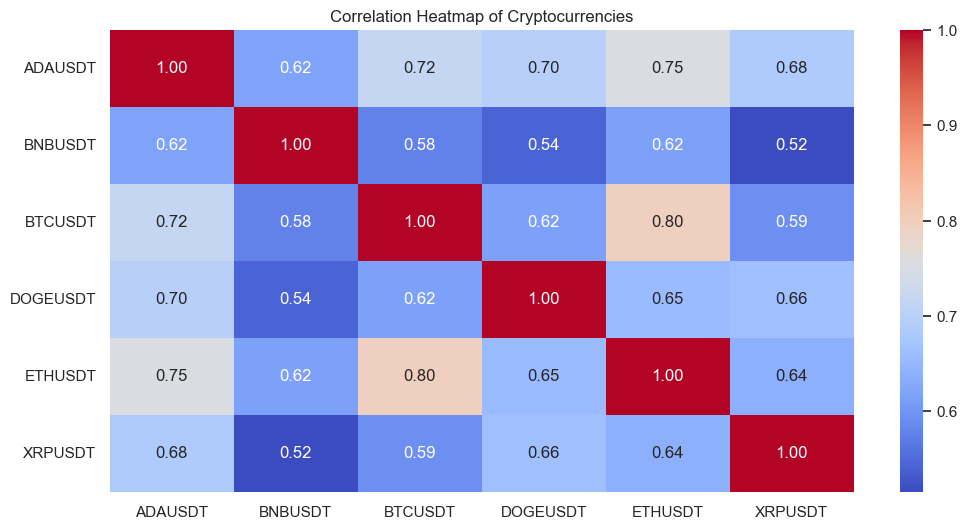

In [14]:
# Create a combined returns dataframe
combined_returns = pd.DataFrame()
for symbol, returns in returns_data.items():
    combined_returns[symbol] = returns['log_returns']
combined_returns.index = list(returns_data.values())[0]['timestamp']

# plot correlation heatmap
corr = combined_returns.corr()
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap of Cryptocurrencies")
plt.show()


ACF Analysis of Log Returns


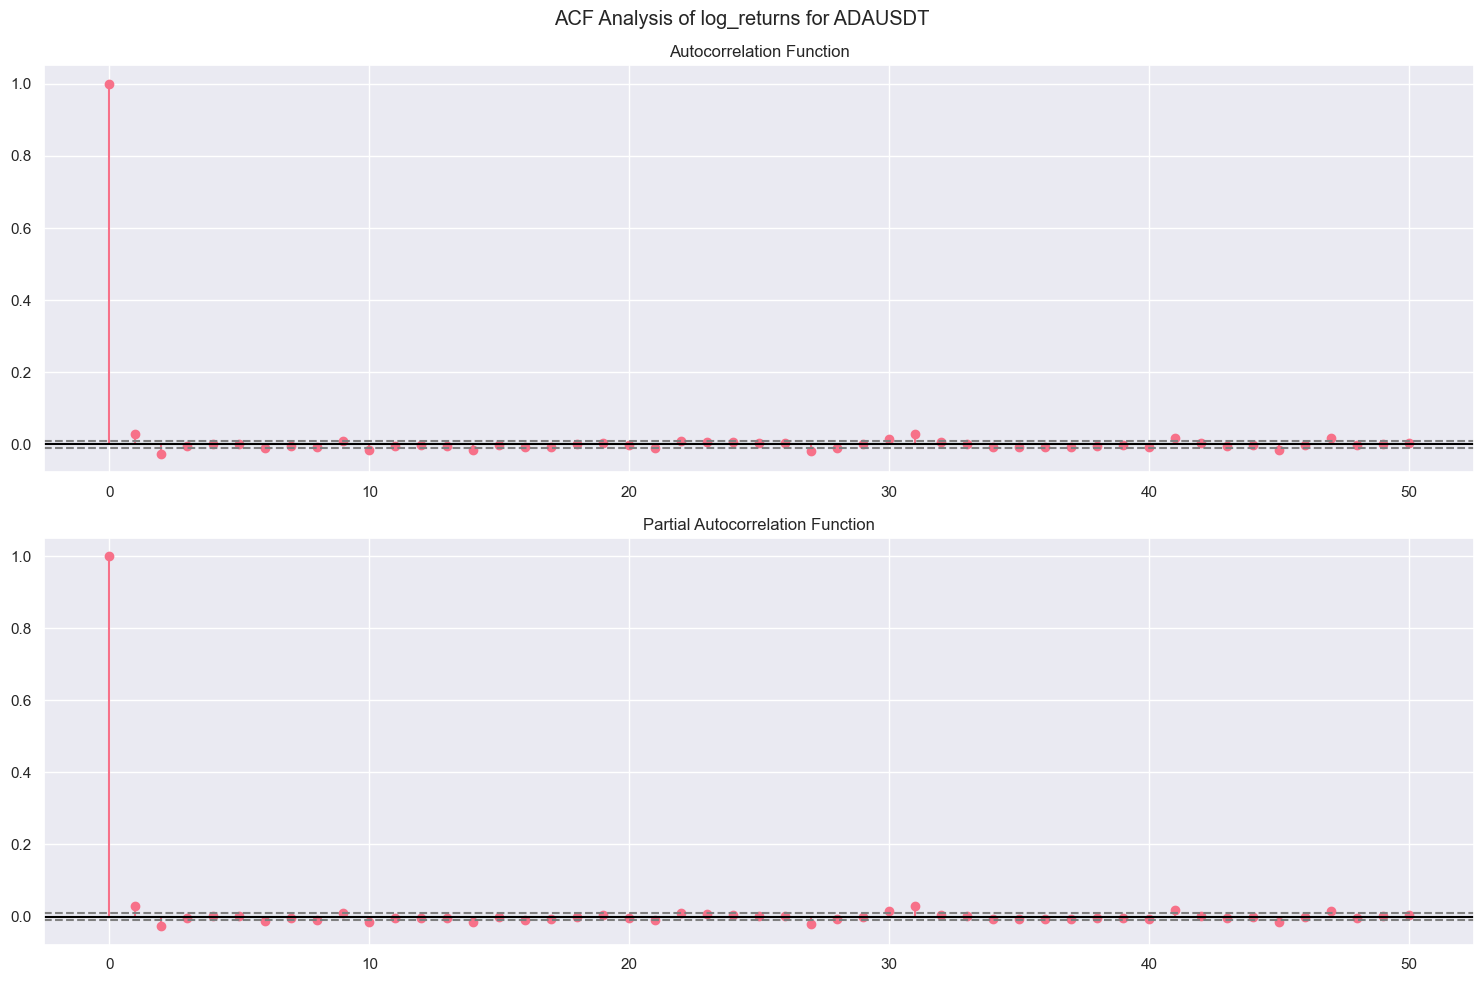

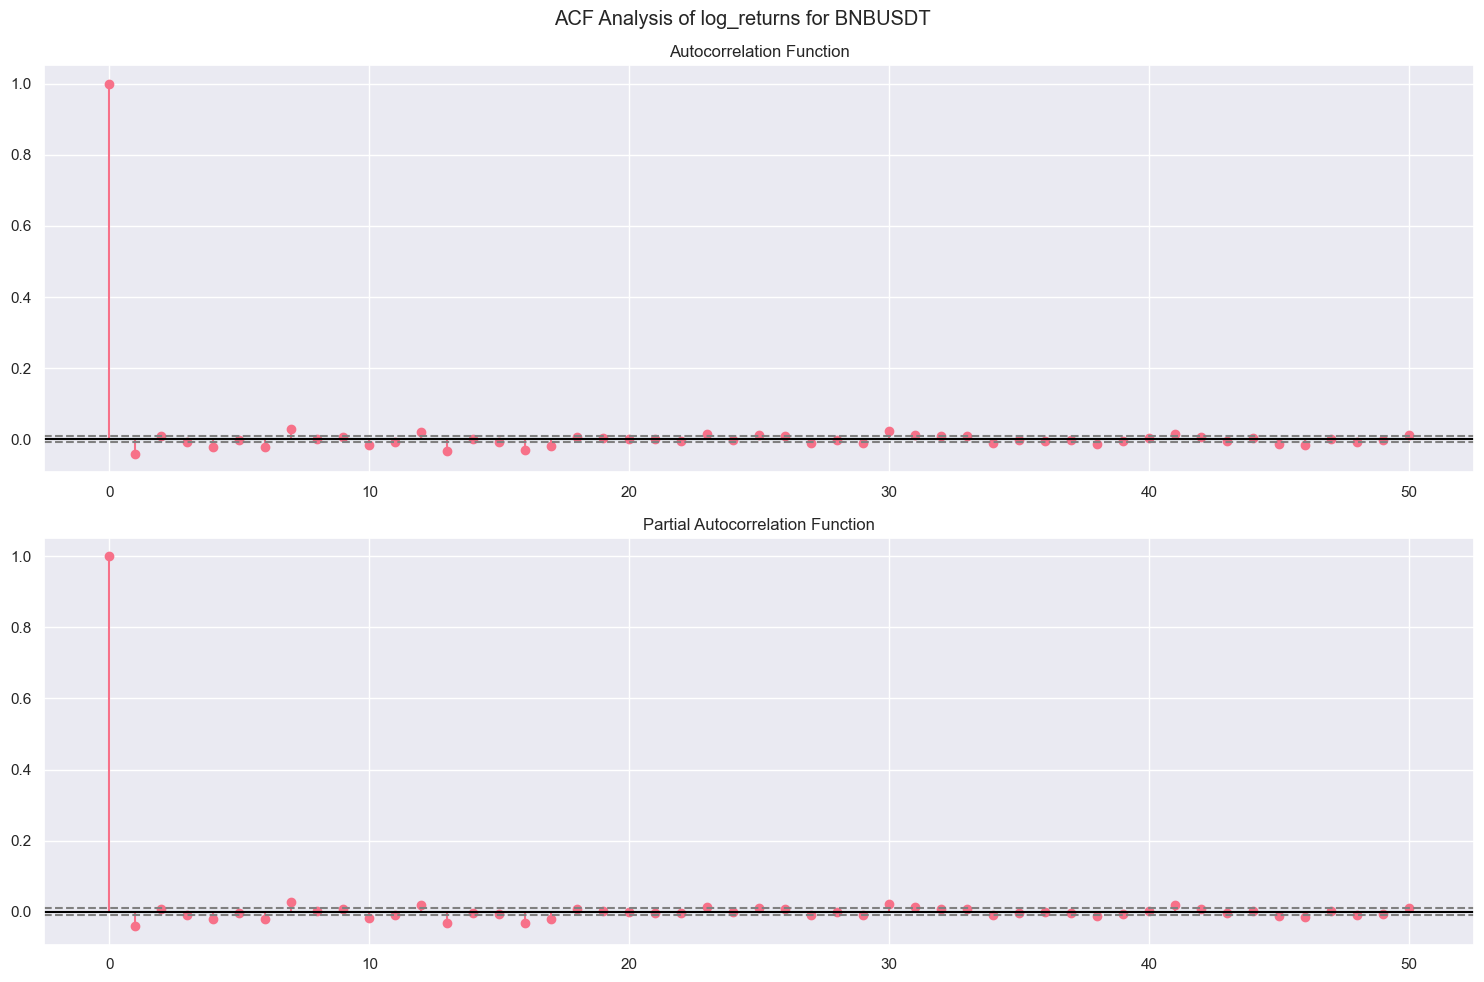

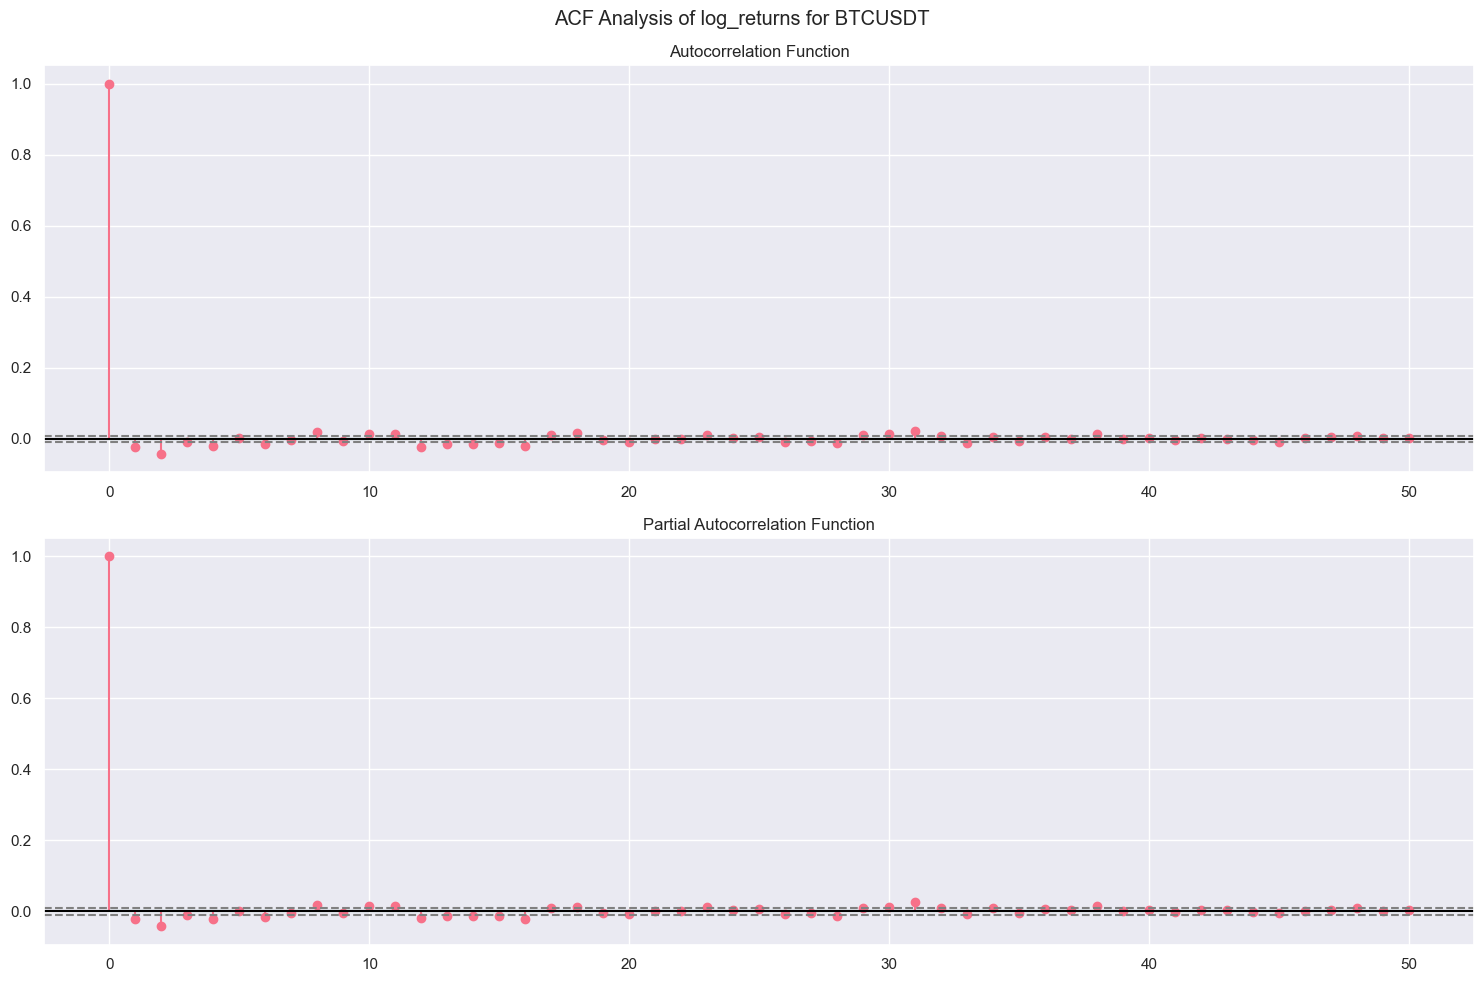

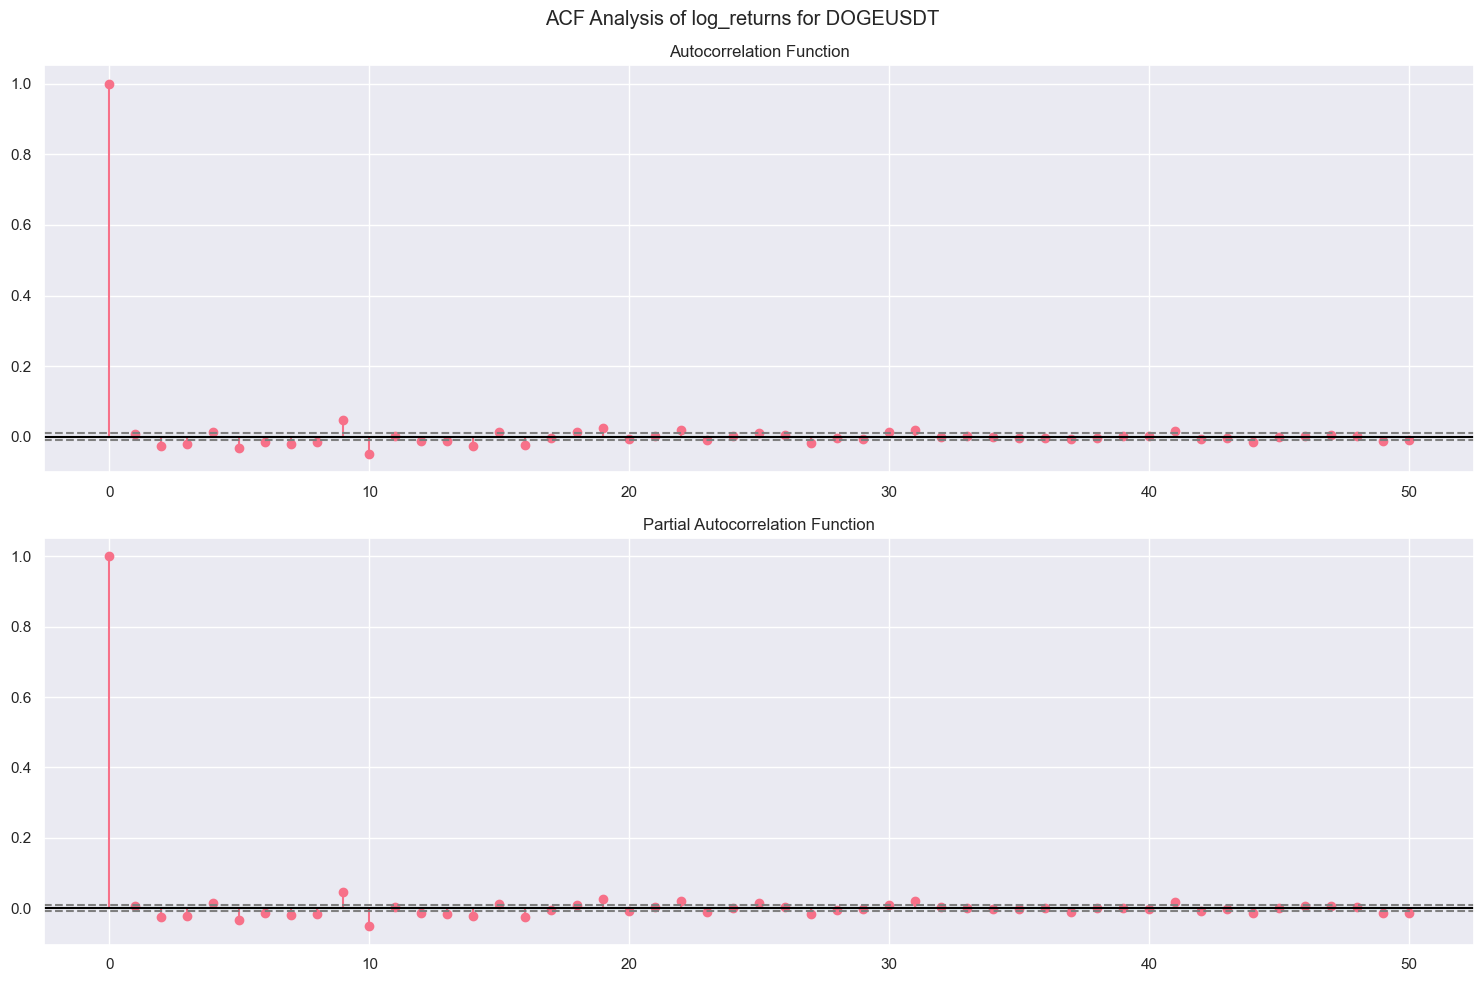

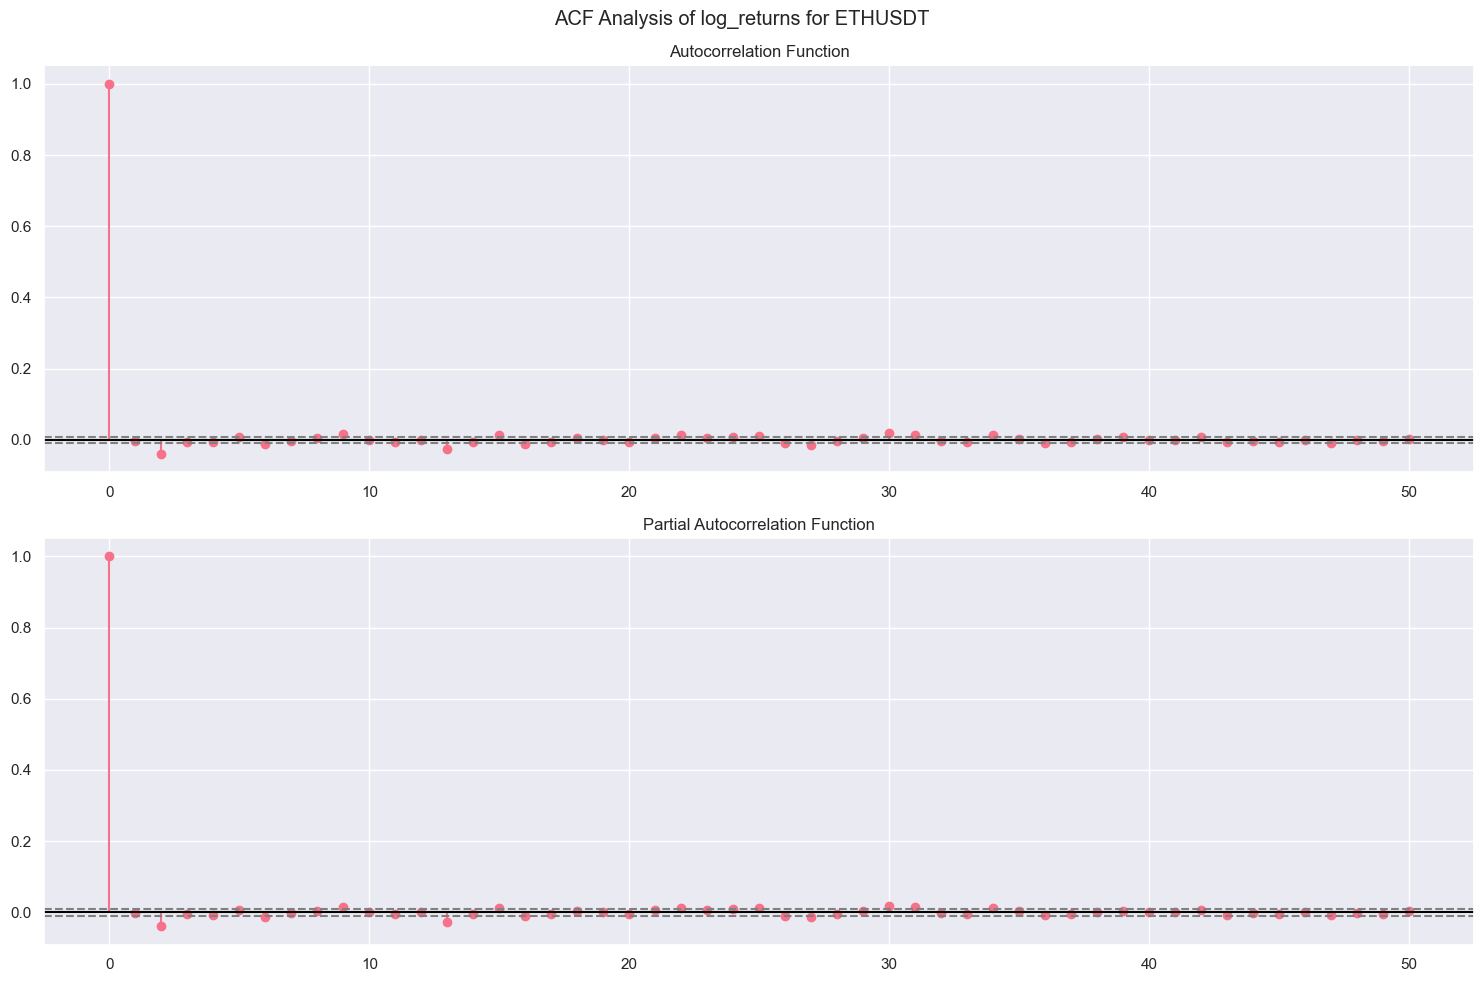

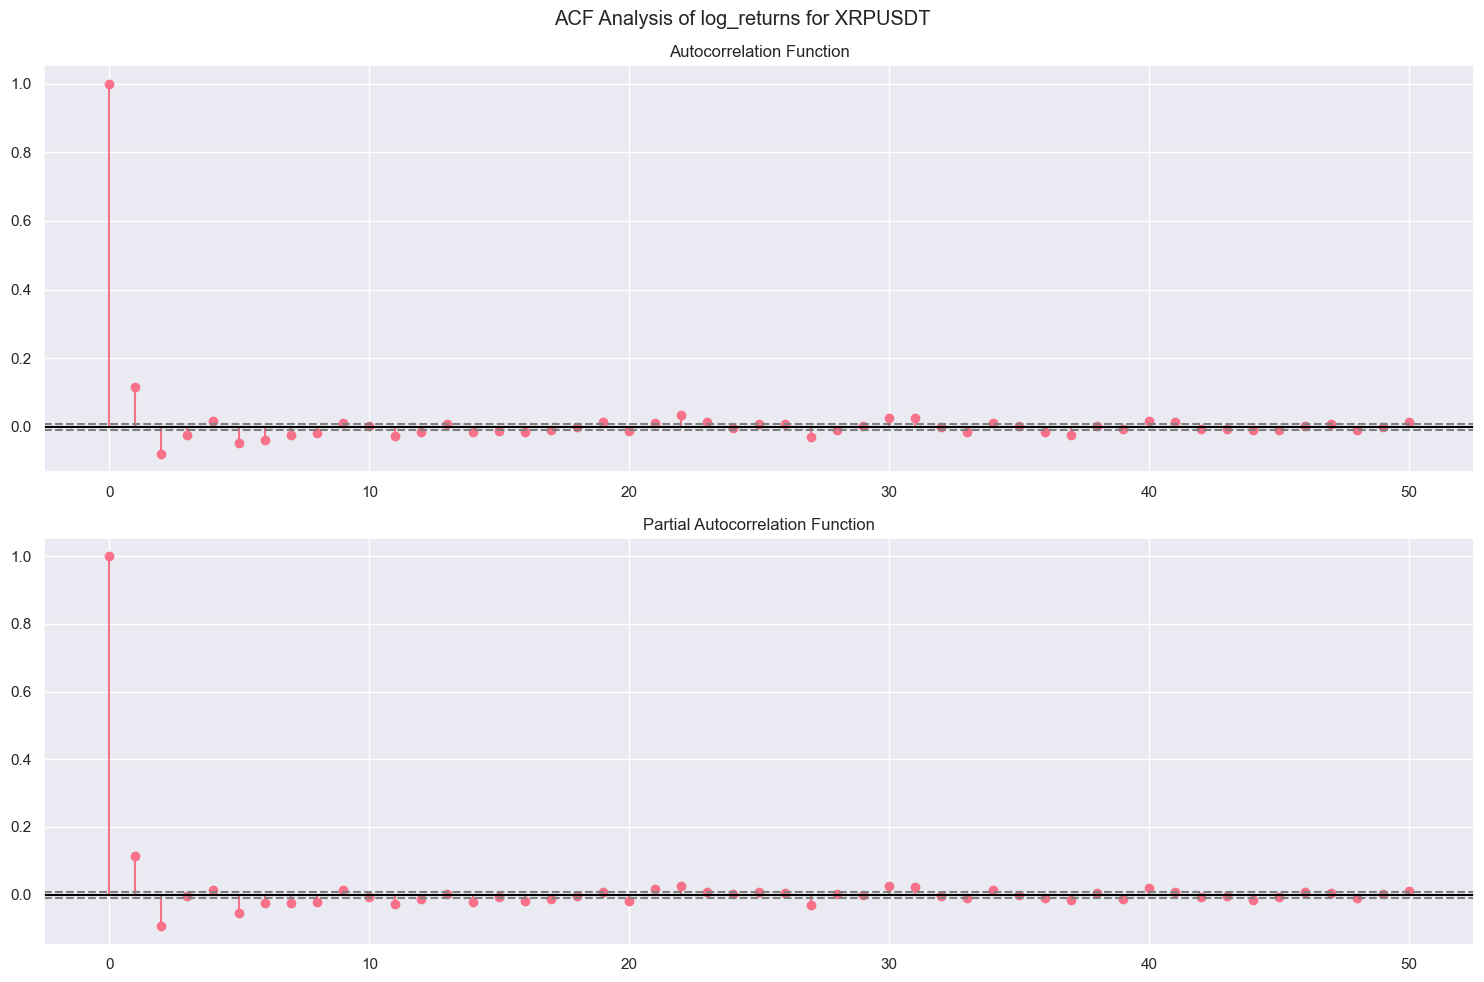


CCF Analysis of Log Returns

Significant lags between ADAUSDT and BNBUSDT:
BNBUSDT leads ADAUSDT by 47 periods (correlation: 0.014)
BNBUSDT leads ADAUSDT by 45 periods (correlation: -0.017)
BNBUSDT leads ADAUSDT by 41 periods (correlation: 0.016)
BNBUSDT leads ADAUSDT by 35 periods (correlation: -0.012)
BNBUSDT leads ADAUSDT by 34 periods (correlation: -0.010)
BNBUSDT leads ADAUSDT by 31 periods (correlation: 0.017)
BNBUSDT leads ADAUSDT by 30 periods (correlation: 0.021)
BNBUSDT leads ADAUSDT by 28 periods (correlation: -0.014)
BNBUSDT leads ADAUSDT by 27 periods (correlation: -0.011)
BNBUSDT leads ADAUSDT by 24 periods (correlation: 0.013)
BNBUSDT leads ADAUSDT by 23 periods (correlation: 0.014)
BNBUSDT leads ADAUSDT by 19 periods (correlation: 0.012)
BNBUSDT leads ADAUSDT by 16 periods (correlation: -0.018)
BNBUSDT leads ADAUSDT by 9 periods (correlation: 0.014)
BNBUSDT leads ADAUSDT by 1 periods (correlation: 0.045)
ADAUSDT leads BNBUSDT by 1 periods (correlation: 0.032)
ADAUSDT l

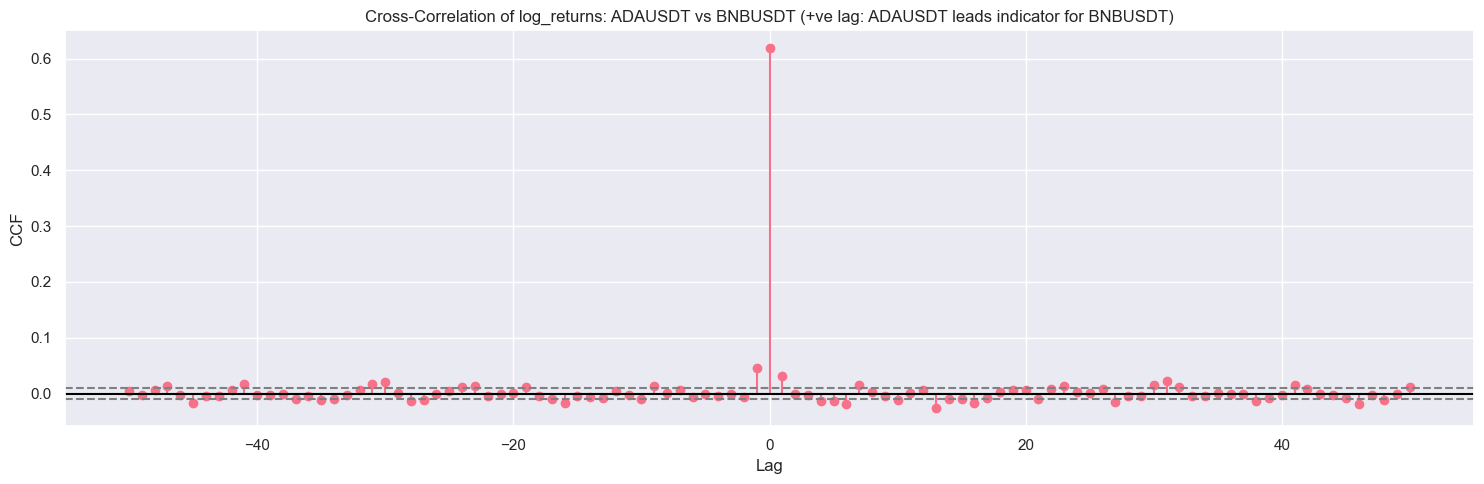


Significant lags between ADAUSDT and BTCUSDT:
BTCUSDT leads ADAUSDT by 47 periods (correlation: 0.013)
BTCUSDT leads ADAUSDT by 45 periods (correlation: -0.012)
BTCUSDT leads ADAUSDT by 41 periods (correlation: 0.010)
BTCUSDT leads ADAUSDT by 38 periods (correlation: 0.015)
BTCUSDT leads ADAUSDT by 31 periods (correlation: 0.020)
BTCUSDT leads ADAUSDT by 30 periods (correlation: 0.014)
BTCUSDT leads ADAUSDT by 28 periods (correlation: -0.014)
BTCUSDT leads ADAUSDT by 26 periods (correlation: -0.011)
BTCUSDT leads ADAUSDT by 23 periods (correlation: 0.014)
BTCUSDT leads ADAUSDT by 16 periods (correlation: -0.017)
BTCUSDT leads ADAUSDT by 9 periods (correlation: 0.015)
BTCUSDT leads ADAUSDT by 7 periods (correlation: 0.011)
BTCUSDT leads ADAUSDT by 6 periods (correlation: -0.013)
BTCUSDT leads ADAUSDT by 2 periods (correlation: -0.025)
BTCUSDT leads ADAUSDT by 1 periods (correlation: 0.043)
ADAUSDT leads BTCUSDT by 2 periods (correlation: -0.052)
ADAUSDT leads BTCUSDT by 3 periods (corr

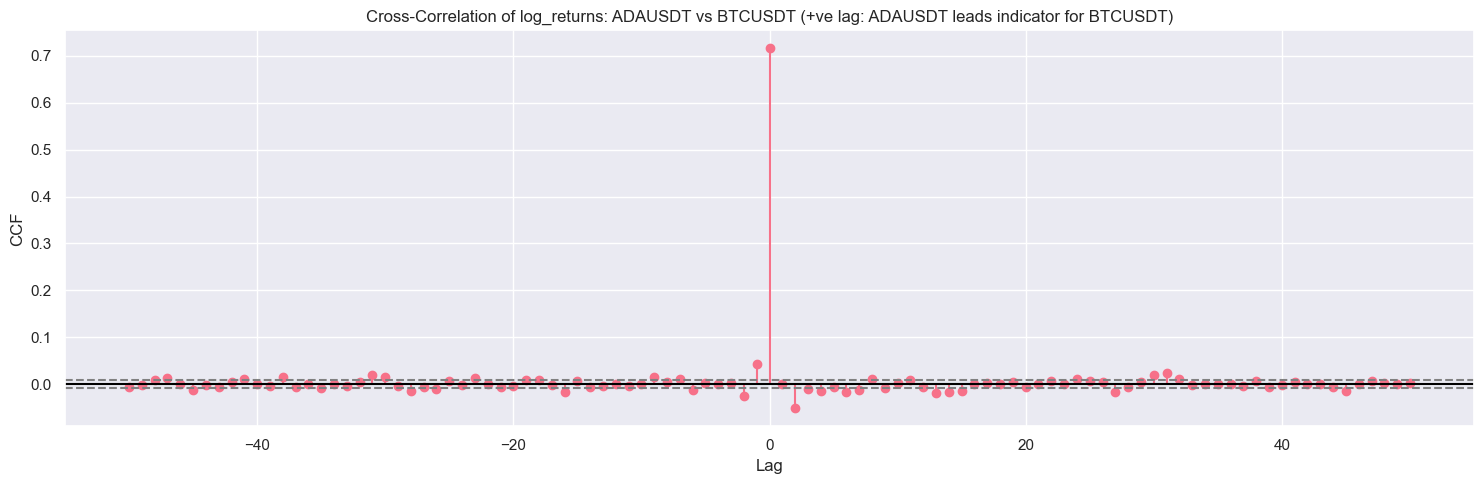


Significant lags between ADAUSDT and DOGEUSDT:
DOGEUSDT leads ADAUSDT by 47 periods (correlation: 0.009)
DOGEUSDT leads ADAUSDT by 41 periods (correlation: 0.015)
DOGEUSDT leads ADAUSDT by 36 periods (correlation: -0.012)
DOGEUSDT leads ADAUSDT by 31 periods (correlation: 0.025)
DOGEUSDT leads ADAUSDT by 30 periods (correlation: 0.014)
DOGEUSDT leads ADAUSDT by 27 periods (correlation: -0.028)
DOGEUSDT leads ADAUSDT by 22 periods (correlation: 0.014)
DOGEUSDT leads ADAUSDT by 18 periods (correlation: 0.010)
DOGEUSDT leads ADAUSDT by 16 periods (correlation: -0.014)
DOGEUSDT leads ADAUSDT by 14 periods (correlation: -0.018)
DOGEUSDT leads ADAUSDT by 10 periods (correlation: -0.013)
DOGEUSDT leads ADAUSDT by 9 periods (correlation: 0.024)
DOGEUSDT leads ADAUSDT by 6 periods (correlation: -0.029)
DOGEUSDT leads ADAUSDT by 5 periods (correlation: -0.010)
DOGEUSDT leads ADAUSDT by 4 periods (correlation: 0.010)
DOGEUSDT leads ADAUSDT by 2 periods (correlation: -0.025)
DOGEUSDT leads ADAUSD

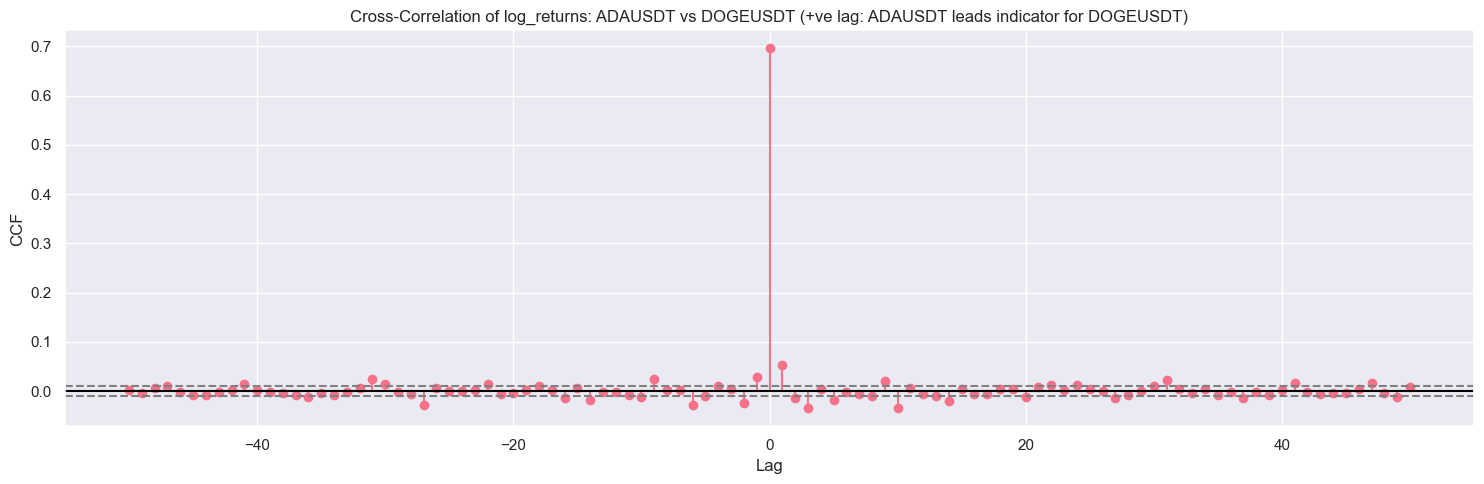


Significant lags between ADAUSDT and ETHUSDT:
ETHUSDT leads ADAUSDT by 45 periods (correlation: -0.011)
ETHUSDT leads ADAUSDT by 41 periods (correlation: 0.013)
ETHUSDT leads ADAUSDT by 31 periods (correlation: 0.020)
ETHUSDT leads ADAUSDT by 30 periods (correlation: 0.014)
ETHUSDT leads ADAUSDT by 28 periods (correlation: -0.012)
ETHUSDT leads ADAUSDT by 27 periods (correlation: -0.017)
ETHUSDT leads ADAUSDT by 23 periods (correlation: 0.015)
ETHUSDT leads ADAUSDT by 20 periods (correlation: -0.013)
ETHUSDT leads ADAUSDT by 16 periods (correlation: -0.010)
ETHUSDT leads ADAUSDT by 14 periods (correlation: -0.012)
ETHUSDT leads ADAUSDT by 10 periods (correlation: -0.016)
ETHUSDT leads ADAUSDT by 9 periods (correlation: 0.017)
ETHUSDT leads ADAUSDT by 7 periods (correlation: 0.012)
ETHUSDT leads ADAUSDT by 6 periods (correlation: -0.010)
ETHUSDT leads ADAUSDT by 4 periods (correlation: 0.013)
ETHUSDT leads ADAUSDT by 2 periods (correlation: -0.023)
ETHUSDT leads ADAUSDT by 1 periods (c

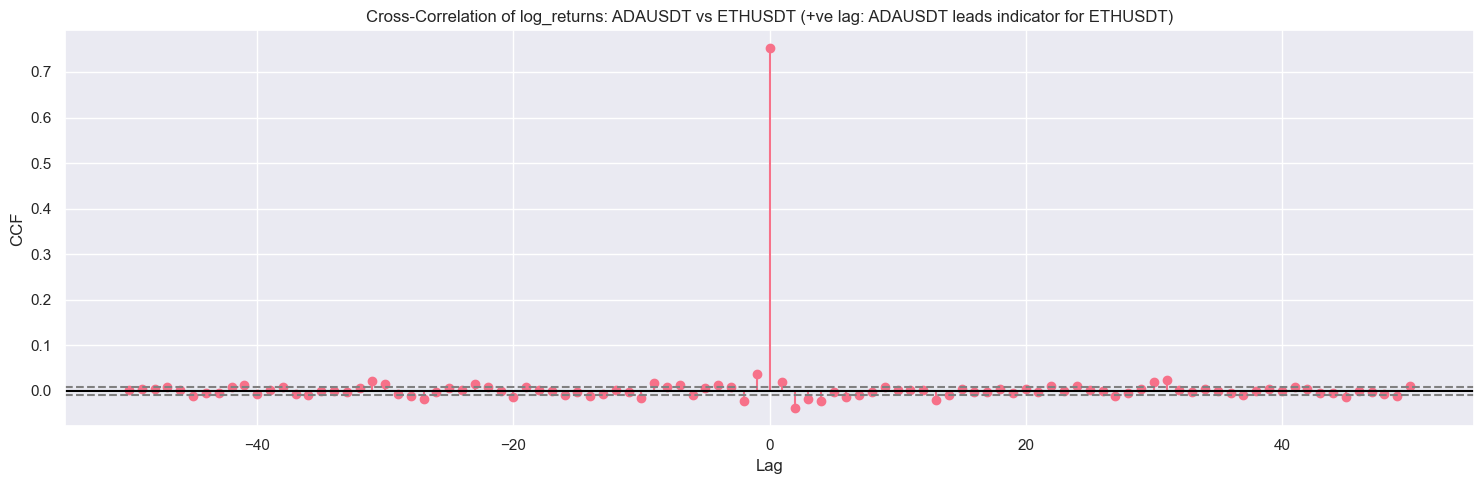


Significant lags between ADAUSDT and XRPUSDT:
XRPUSDT leads ADAUSDT by 50 periods (correlation: 0.015)
XRPUSDT leads ADAUSDT by 47 periods (correlation: 0.013)
XRPUSDT leads ADAUSDT by 45 periods (correlation: -0.023)
XRPUSDT leads ADAUSDT by 44 periods (correlation: -0.012)
XRPUSDT leads ADAUSDT by 43 periods (correlation: -0.011)
XRPUSDT leads ADAUSDT by 41 periods (correlation: 0.016)
XRPUSDT leads ADAUSDT by 37 periods (correlation: -0.016)
XRPUSDT leads ADAUSDT by 36 periods (correlation: -0.019)
XRPUSDT leads ADAUSDT by 31 periods (correlation: 0.021)
XRPUSDT leads ADAUSDT by 30 periods (correlation: 0.028)
XRPUSDT leads ADAUSDT by 28 periods (correlation: -0.010)
XRPUSDT leads ADAUSDT by 27 periods (correlation: -0.020)
XRPUSDT leads ADAUSDT by 26 periods (correlation: -0.012)
XRPUSDT leads ADAUSDT by 23 periods (correlation: 0.014)
XRPUSDT leads ADAUSDT by 22 periods (correlation: 0.022)
XRPUSDT leads ADAUSDT by 20 periods (correlation: -0.013)
XRPUSDT leads ADAUSDT by 14 peri

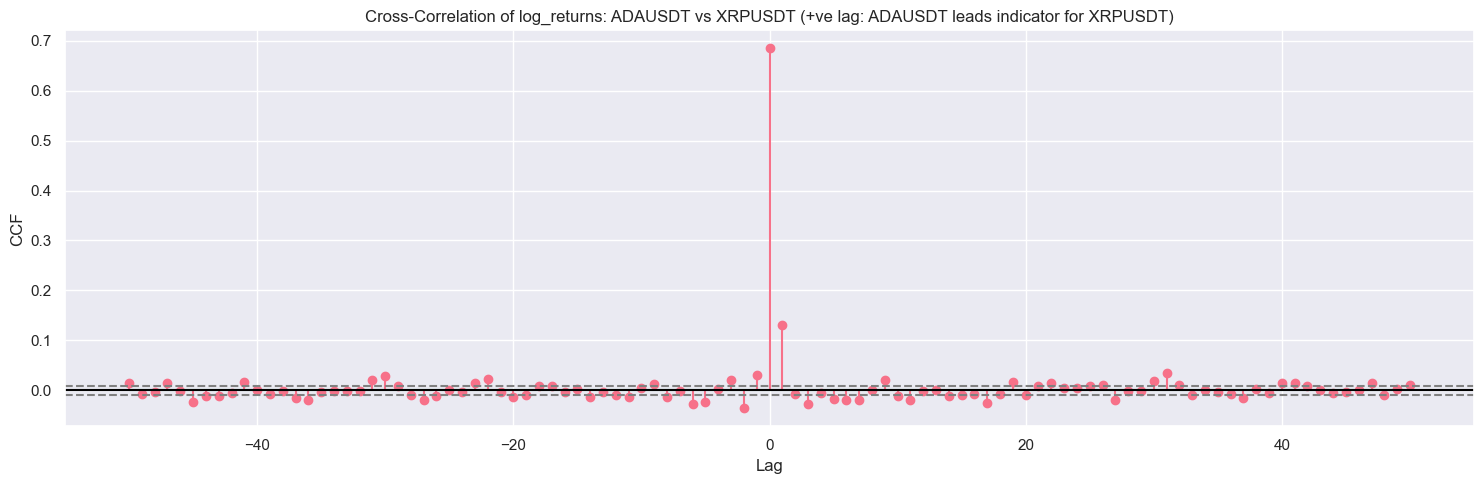


Significant lags between BNBUSDT and BTCUSDT:
BTCUSDT leads BNBUSDT by 42 periods (correlation: 0.010)
BTCUSDT leads BNBUSDT by 41 periods (correlation: 0.010)
BTCUSDT leads BNBUSDT by 31 periods (correlation: 0.020)
BTCUSDT leads BNBUSDT by 24 periods (correlation: -0.010)
BTCUSDT leads BNBUSDT by 23 periods (correlation: 0.014)
BTCUSDT leads BNBUSDT by 21 periods (correlation: -0.012)
BTCUSDT leads BNBUSDT by 16 periods (correlation: -0.021)
BTCUSDT leads BNBUSDT by 15 periods (correlation: 0.014)
BTCUSDT leads BNBUSDT by 13 periods (correlation: -0.026)
BTCUSDT leads BNBUSDT by 12 periods (correlation: 0.010)
BTCUSDT leads BNBUSDT by 8 periods (correlation: 0.013)
BTCUSDT leads BNBUSDT by 7 periods (correlation: 0.015)
BTCUSDT leads BNBUSDT by 6 periods (correlation: -0.013)
BTCUSDT leads BNBUSDT by 1 periods (correlation: 0.019)
BNBUSDT leads BTCUSDT by 1 periods (correlation: 0.013)
BNBUSDT leads BTCUSDT by 2 periods (correlation: -0.034)
BNBUSDT leads BTCUSDT by 4 periods (corre

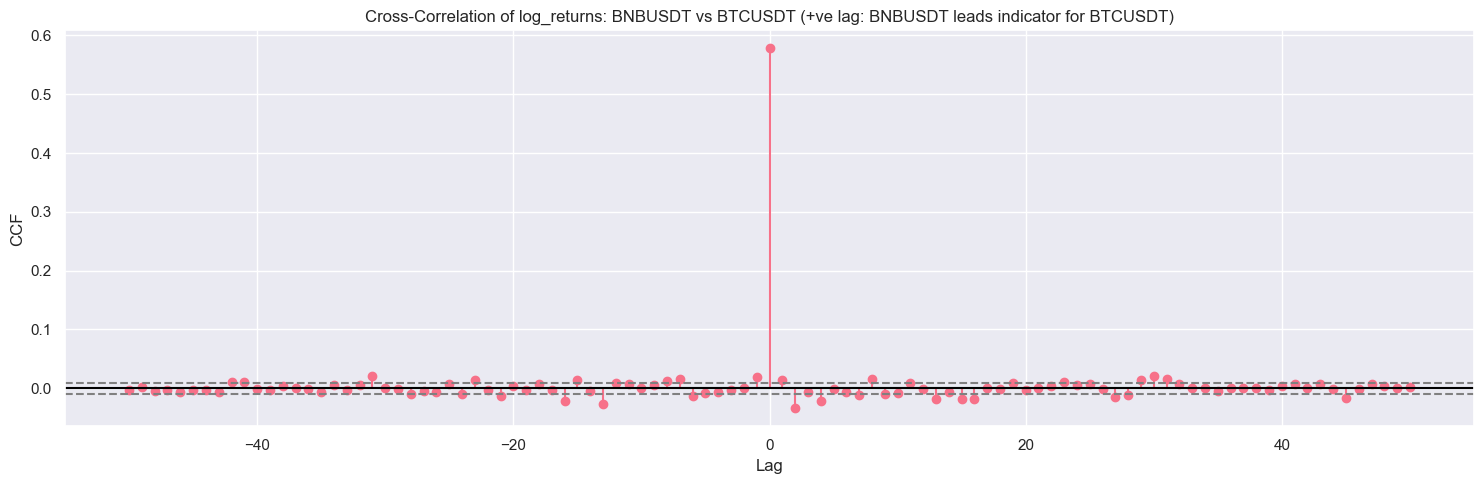


Significant lags between BNBUSDT and DOGEUSDT:
DOGEUSDT leads BNBUSDT by 47 periods (correlation: -0.013)
DOGEUSDT leads BNBUSDT by 46 periods (correlation: -0.022)
DOGEUSDT leads BNBUSDT by 41 periods (correlation: 0.012)
DOGEUSDT leads BNBUSDT by 38 periods (correlation: -0.018)
DOGEUSDT leads BNBUSDT by 31 periods (correlation: 0.026)
DOGEUSDT leads BNBUSDT by 27 periods (correlation: -0.027)
DOGEUSDT leads BNBUSDT by 26 periods (correlation: 0.022)
DOGEUSDT leads BNBUSDT by 23 periods (correlation: 0.009)
DOGEUSDT leads BNBUSDT by 22 periods (correlation: 0.010)
DOGEUSDT leads BNBUSDT by 16 periods (correlation: -0.027)
DOGEUSDT leads BNBUSDT by 13 periods (correlation: -0.040)
DOGEUSDT leads BNBUSDT by 7 periods (correlation: 0.021)
DOGEUSDT leads BNBUSDT by 6 periods (correlation: -0.028)
DOGEUSDT leads BNBUSDT by 5 periods (correlation: -0.016)
DOGEUSDT leads BNBUSDT by 4 periods (correlation: -0.010)
DOGEUSDT leads BNBUSDT by 2 periods (correlation: -0.014)
DOGEUSDT leads BNBU

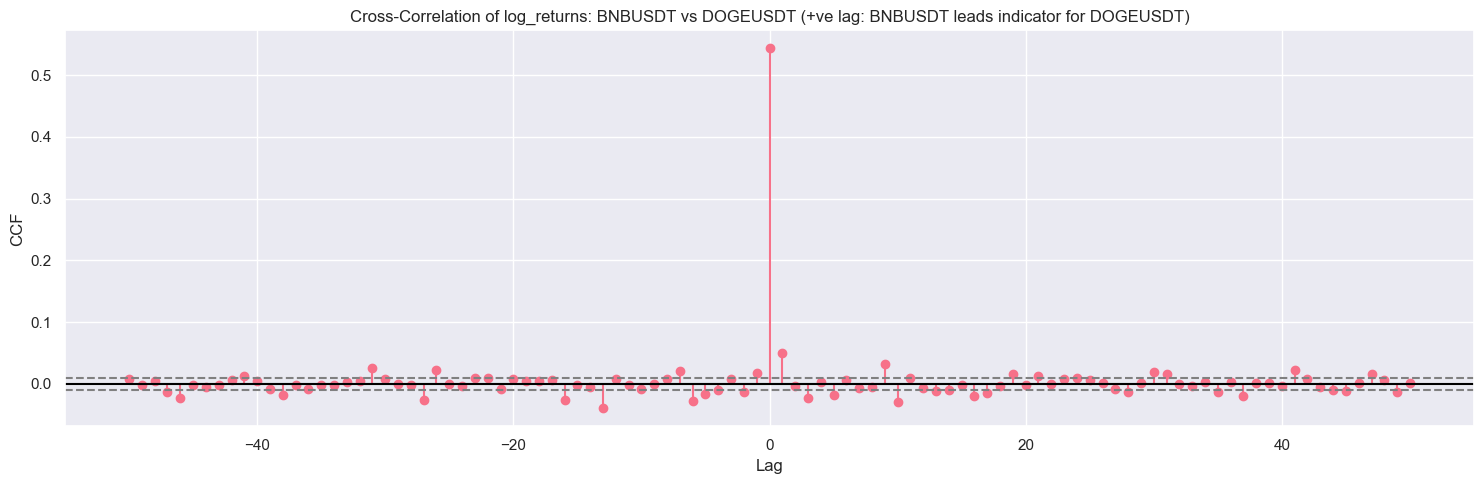


Significant lags between BNBUSDT and ETHUSDT:
ETHUSDT leads BNBUSDT by 46 periods (correlation: -0.014)
ETHUSDT leads BNBUSDT by 42 periods (correlation: 0.011)
ETHUSDT leads BNBUSDT by 31 periods (correlation: 0.020)
ETHUSDT leads BNBUSDT by 27 periods (correlation: -0.016)
ETHUSDT leads BNBUSDT by 23 periods (correlation: 0.016)
ETHUSDT leads BNBUSDT by 16 periods (correlation: -0.016)
ETHUSDT leads BNBUSDT by 13 periods (correlation: -0.028)
ETHUSDT leads BNBUSDT by 10 periods (correlation: -0.010)
ETHUSDT leads BNBUSDT by 8 periods (correlation: 0.013)
ETHUSDT leads BNBUSDT by 7 periods (correlation: 0.022)
ETHUSDT leads BNBUSDT by 6 periods (correlation: -0.018)
ETHUSDT leads BNBUSDT by 1 periods (correlation: 0.010)
BNBUSDT leads ETHUSDT by 1 periods (correlation: 0.017)
BNBUSDT leads ETHUSDT by 2 periods (correlation: -0.021)
BNBUSDT leads ETHUSDT by 4 periods (correlation: -0.024)
BNBUSDT leads ETHUSDT by 8 periods (correlation: 0.009)
BNBUSDT leads ETHUSDT by 13 periods (corr

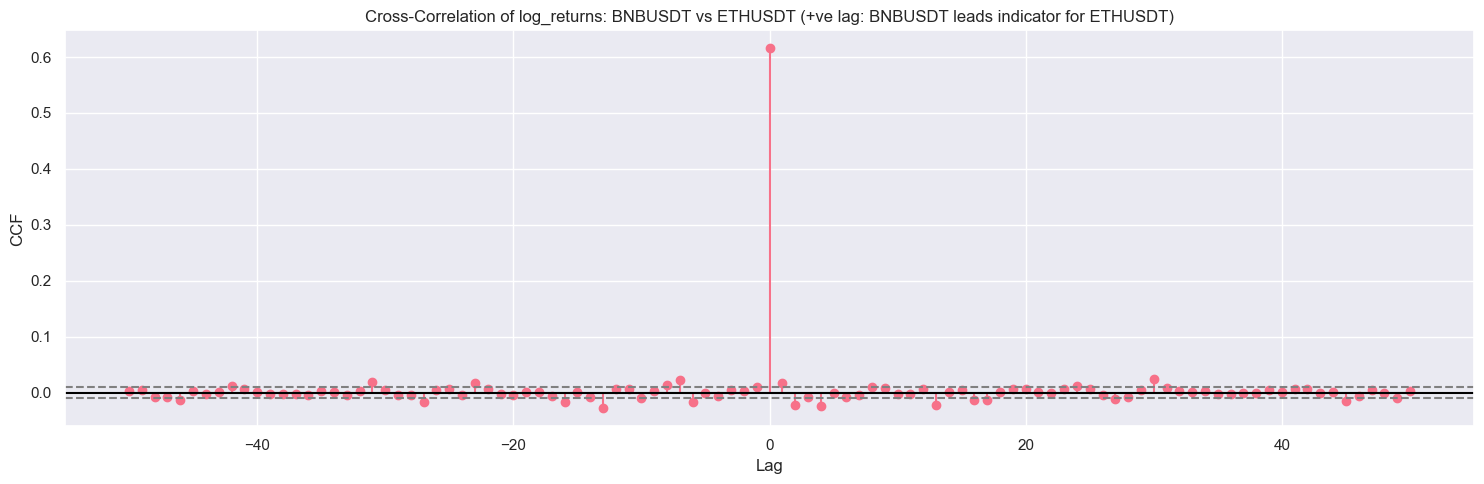


Significant lags between BNBUSDT and XRPUSDT:
XRPUSDT leads BNBUSDT by 50 periods (correlation: 0.021)
XRPUSDT leads BNBUSDT by 46 periods (correlation: -0.037)
XRPUSDT leads BNBUSDT by 45 periods (correlation: -0.019)
XRPUSDT leads BNBUSDT by 41 periods (correlation: 0.019)
XRPUSDT leads BNBUSDT by 39 periods (correlation: -0.012)
XRPUSDT leads BNBUSDT by 38 periods (correlation: -0.021)
XRPUSDT leads BNBUSDT by 37 periods (correlation: -0.014)
XRPUSDT leads BNBUSDT by 31 periods (correlation: 0.022)
XRPUSDT leads BNBUSDT by 30 periods (correlation: 0.025)
XRPUSDT leads BNBUSDT by 29 periods (correlation: 0.012)
XRPUSDT leads BNBUSDT by 28 periods (correlation: -0.011)
XRPUSDT leads BNBUSDT by 27 periods (correlation: -0.022)
XRPUSDT leads BNBUSDT by 23 periods (correlation: 0.023)
XRPUSDT leads BNBUSDT by 22 periods (correlation: 0.015)
XRPUSDT leads BNBUSDT by 19 periods (correlation: -0.010)
XRPUSDT leads BNBUSDT by 18 periods (correlation: 0.010)
XRPUSDT leads BNBUSDT by 16 perio

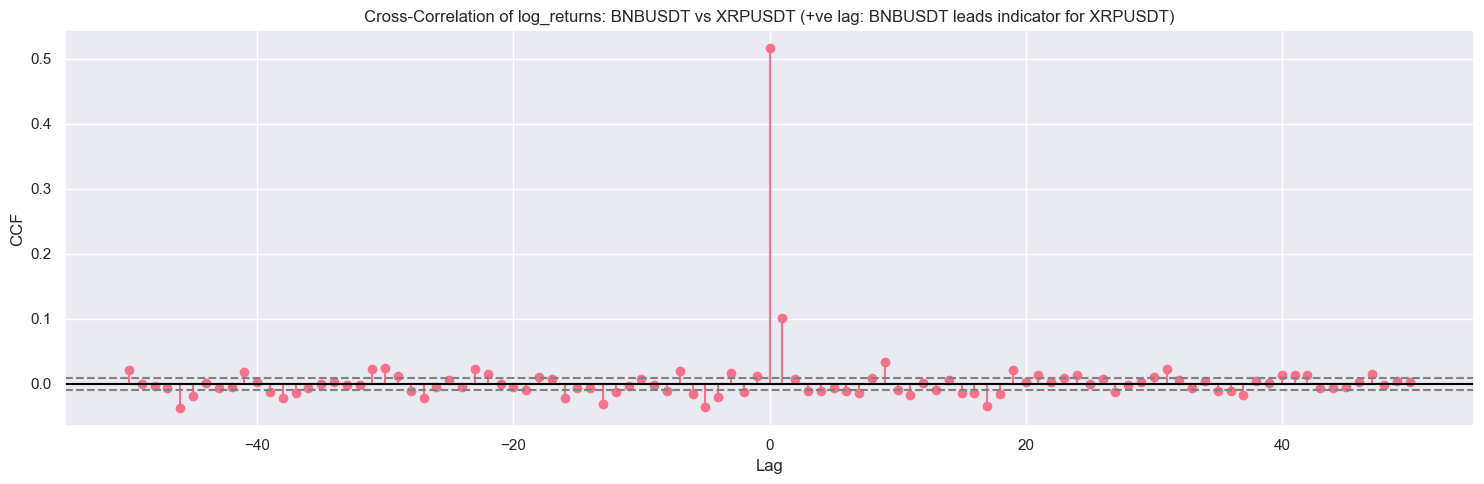


Significant lags between BTCUSDT and DOGEUSDT:
DOGEUSDT leads BTCUSDT by 48 periods (correlation: 0.010)
DOGEUSDT leads BTCUSDT by 44 periods (correlation: -0.013)
DOGEUSDT leads BTCUSDT by 32 periods (correlation: 0.010)
DOGEUSDT leads BTCUSDT by 31 periods (correlation: 0.017)
DOGEUSDT leads BTCUSDT by 30 periods (correlation: 0.017)
DOGEUSDT leads BTCUSDT by 27 periods (correlation: -0.018)
DOGEUSDT leads BTCUSDT by 17 periods (correlation: 0.014)
DOGEUSDT leads BTCUSDT by 16 periods (correlation: -0.013)
DOGEUSDT leads BTCUSDT by 15 periods (correlation: -0.011)
DOGEUSDT leads BTCUSDT by 14 periods (correlation: -0.020)
DOGEUSDT leads BTCUSDT by 13 periods (correlation: -0.019)
DOGEUSDT leads BTCUSDT by 8 periods (correlation: 0.027)
DOGEUSDT leads BTCUSDT by 7 periods (correlation: -0.012)
DOGEUSDT leads BTCUSDT by 6 periods (correlation: -0.029)
DOGEUSDT leads BTCUSDT by 5 periods (correlation: -0.016)
DOGEUSDT leads BTCUSDT by 4 periods (correlation: -0.010)
DOGEUSDT leads BTCU

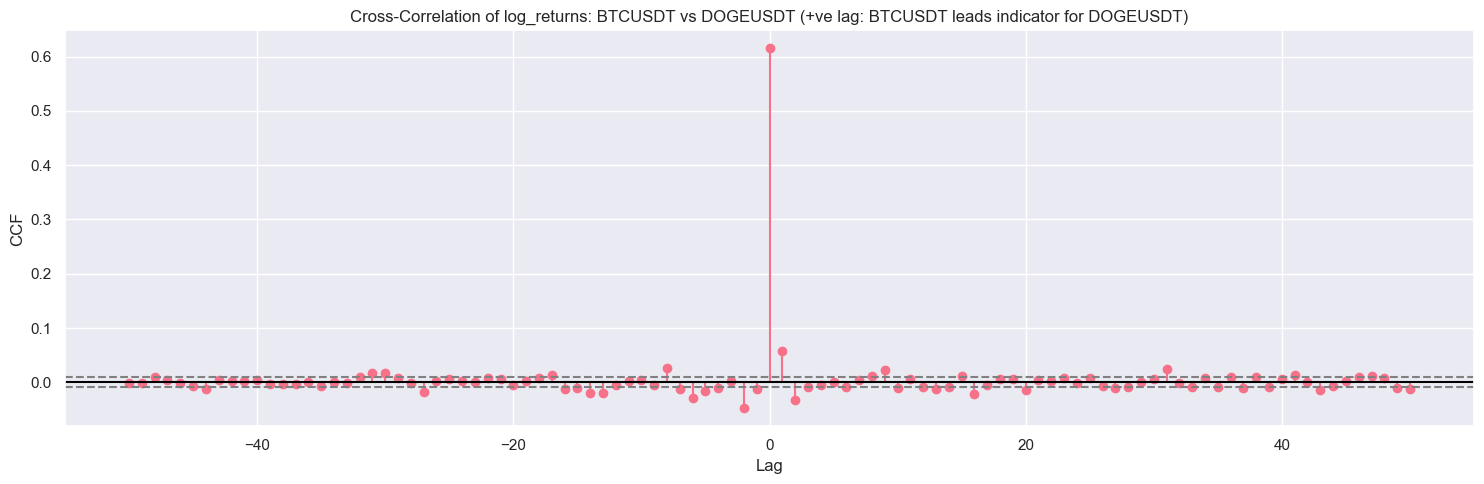


Significant lags between BTCUSDT and ETHUSDT:
ETHUSDT leads BTCUSDT by 42 periods (correlation: 0.014)
ETHUSDT leads BTCUSDT by 33 periods (correlation: -0.010)
ETHUSDT leads BTCUSDT by 31 periods (correlation: 0.017)
ETHUSDT leads BTCUSDT by 27 periods (correlation: -0.019)
ETHUSDT leads BTCUSDT by 26 periods (correlation: -0.010)
ETHUSDT leads BTCUSDT by 22 periods (correlation: 0.012)
ETHUSDT leads BTCUSDT by 20 periods (correlation: -0.014)
ETHUSDT leads BTCUSDT by 16 periods (correlation: -0.015)
ETHUSDT leads BTCUSDT by 15 periods (correlation: -0.015)
ETHUSDT leads BTCUSDT by 14 periods (correlation: -0.014)
ETHUSDT leads BTCUSDT by 13 periods (correlation: -0.019)
ETHUSDT leads BTCUSDT by 12 periods (correlation: -0.014)
ETHUSDT leads BTCUSDT by 11 periods (correlation: 0.012)
ETHUSDT leads BTCUSDT by 9 periods (correlation: -0.010)
ETHUSDT leads BTCUSDT by 8 periods (correlation: 0.016)
ETHUSDT leads BTCUSDT by 6 periods (correlation: -0.018)
ETHUSDT leads BTCUSDT by 4 period

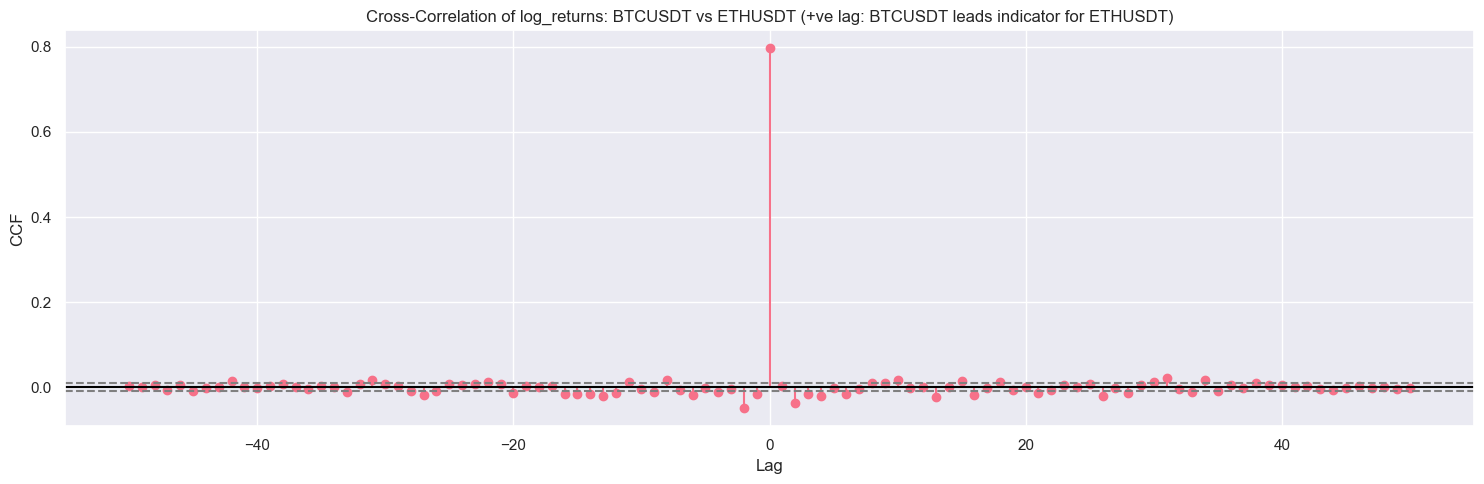


Significant lags between BTCUSDT and XRPUSDT:
XRPUSDT leads BTCUSDT by 50 periods (correlation: 0.013)
XRPUSDT leads BTCUSDT by 45 periods (correlation: -0.015)
XRPUSDT leads BTCUSDT by 44 periods (correlation: -0.012)
XRPUSDT leads BTCUSDT by 31 periods (correlation: 0.012)
XRPUSDT leads BTCUSDT by 30 periods (correlation: 0.027)
XRPUSDT leads BTCUSDT by 29 periods (correlation: 0.013)
XRPUSDT leads BTCUSDT by 27 periods (correlation: -0.015)
XRPUSDT leads BTCUSDT by 26 periods (correlation: -0.011)
XRPUSDT leads BTCUSDT by 23 periods (correlation: 0.013)
XRPUSDT leads BTCUSDT by 22 periods (correlation: 0.009)
XRPUSDT leads BTCUSDT by 17 periods (correlation: 0.013)
XRPUSDT leads BTCUSDT by 15 periods (correlation: -0.012)
XRPUSDT leads BTCUSDT by 14 periods (correlation: -0.016)
XRPUSDT leads BTCUSDT by 13 periods (correlation: -0.014)
XRPUSDT leads BTCUSDT by 12 periods (correlation: -0.017)
XRPUSDT leads BTCUSDT by 10 periods (correlation: 0.015)
XRPUSDT leads BTCUSDT by 8 period

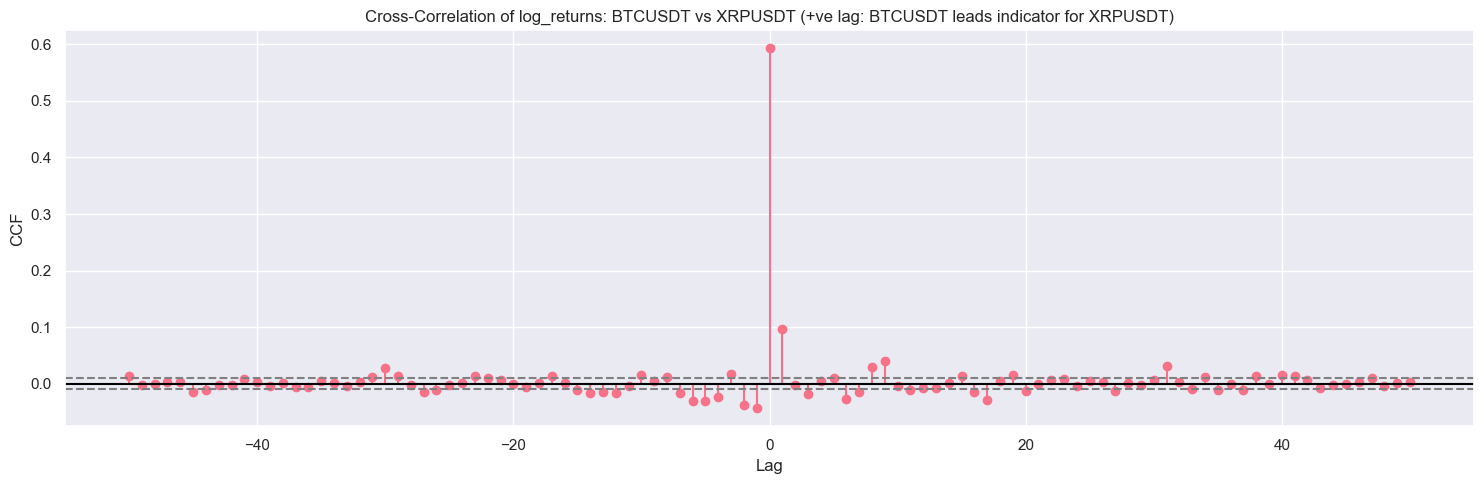


Significant lags between DOGEUSDT and ETHUSDT:
ETHUSDT leads DOGEUSDT by 47 periods (correlation: 0.010)
ETHUSDT leads DOGEUSDT by 43 periods (correlation: -0.010)
ETHUSDT leads DOGEUSDT by 38 periods (correlation: 0.009)
ETHUSDT leads DOGEUSDT by 37 periods (correlation: -0.013)
ETHUSDT leads DOGEUSDT by 34 periods (correlation: 0.013)
ETHUSDT leads DOGEUSDT by 31 periods (correlation: 0.021)
ETHUSDT leads DOGEUSDT by 30 periods (correlation: 0.014)
ETHUSDT leads DOGEUSDT by 27 periods (correlation: -0.018)
ETHUSDT leads DOGEUSDT by 22 periods (correlation: 0.012)
ETHUSDT leads DOGEUSDT by 20 periods (correlation: -0.025)
ETHUSDT leads DOGEUSDT by 16 periods (correlation: -0.013)
ETHUSDT leads DOGEUSDT by 14 periods (correlation: -0.015)
ETHUSDT leads DOGEUSDT by 13 periods (correlation: -0.015)
ETHUSDT leads DOGEUSDT by 10 periods (correlation: -0.032)
ETHUSDT leads DOGEUSDT by 9 periods (correlation: 0.035)
ETHUSDT leads DOGEUSDT by 5 periods (correlation: -0.009)
ETHUSDT leads DOG

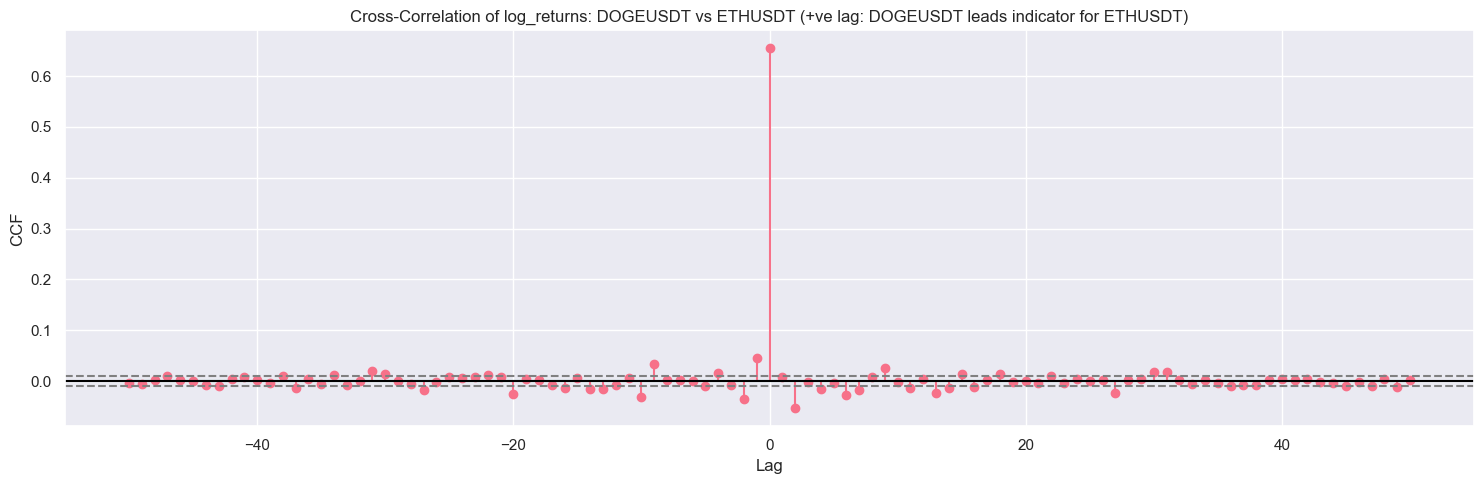


Significant lags between DOGEUSDT and XRPUSDT:
XRPUSDT leads DOGEUSDT by 50 periods (correlation: 0.012)
XRPUSDT leads DOGEUSDT by 49 periods (correlation: -0.014)
XRPUSDT leads DOGEUSDT by 43 periods (correlation: -0.013)
XRPUSDT leads DOGEUSDT by 41 periods (correlation: 0.020)
XRPUSDT leads DOGEUSDT by 39 periods (correlation: -0.013)
XRPUSDT leads DOGEUSDT by 37 periods (correlation: -0.020)
XRPUSDT leads DOGEUSDT by 36 periods (correlation: -0.011)
XRPUSDT leads DOGEUSDT by 31 periods (correlation: 0.016)
XRPUSDT leads DOGEUSDT by 30 periods (correlation: 0.023)
XRPUSDT leads DOGEUSDT by 28 periods (correlation: -0.010)
XRPUSDT leads DOGEUSDT by 27 periods (correlation: -0.020)
XRPUSDT leads DOGEUSDT by 23 periods (correlation: 0.011)
XRPUSDT leads DOGEUSDT by 22 periods (correlation: 0.027)
XRPUSDT leads DOGEUSDT by 21 periods (correlation: 0.013)
XRPUSDT leads DOGEUSDT by 20 periods (correlation: -0.017)
XRPUSDT leads DOGEUSDT by 18 periods (correlation: 0.011)
XRPUSDT leads DO

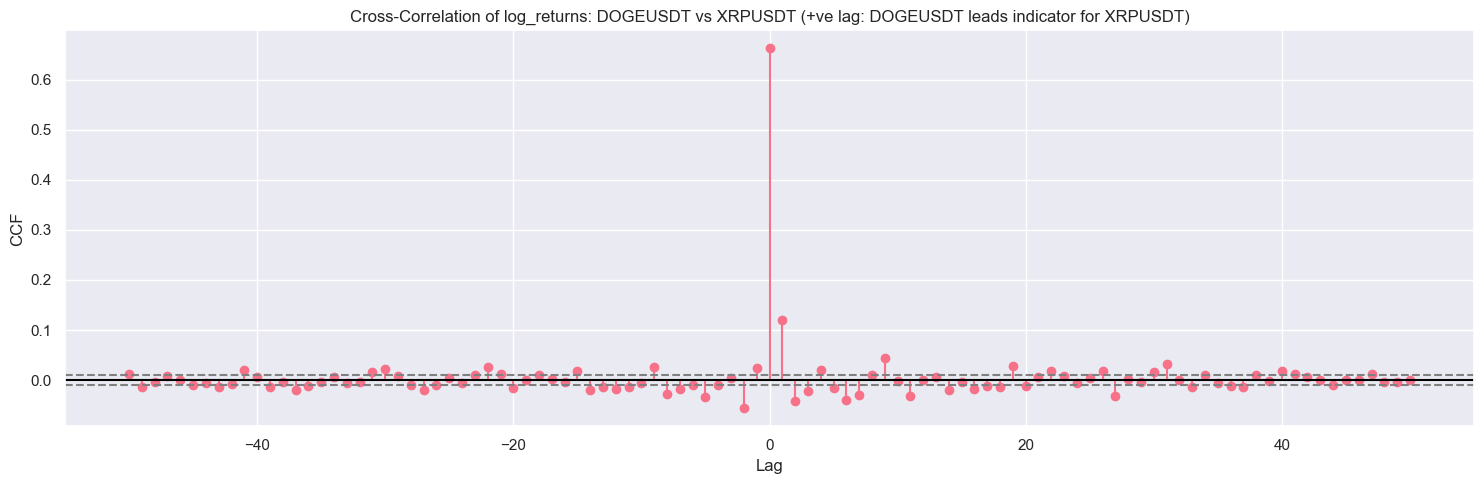


Significant lags between ETHUSDT and XRPUSDT:
XRPUSDT leads ETHUSDT by 50 periods (correlation: 0.012)
XRPUSDT leads ETHUSDT by 49 periods (correlation: -0.013)
XRPUSDT leads ETHUSDT by 48 periods (correlation: -0.010)
XRPUSDT leads ETHUSDT by 45 periods (correlation: -0.019)
XRPUSDT leads ETHUSDT by 41 periods (correlation: 0.010)
XRPUSDT leads ETHUSDT by 37 periods (correlation: -0.013)
XRPUSDT leads ETHUSDT by 36 periods (correlation: -0.014)
XRPUSDT leads ETHUSDT by 31 periods (correlation: 0.015)
XRPUSDT leads ETHUSDT by 30 periods (correlation: 0.031)
XRPUSDT leads ETHUSDT by 29 periods (correlation: 0.016)
XRPUSDT leads ETHUSDT by 27 periods (correlation: -0.014)
XRPUSDT leads ETHUSDT by 26 periods (correlation: -0.015)
XRPUSDT leads ETHUSDT by 22 periods (correlation: 0.013)
XRPUSDT leads ETHUSDT by 19 periods (correlation: -0.012)
XRPUSDT leads ETHUSDT by 18 periods (correlation: 0.011)
XRPUSDT leads ETHUSDT by 15 periods (correlation: 0.017)
XRPUSDT leads ETHUSDT by 13 perio

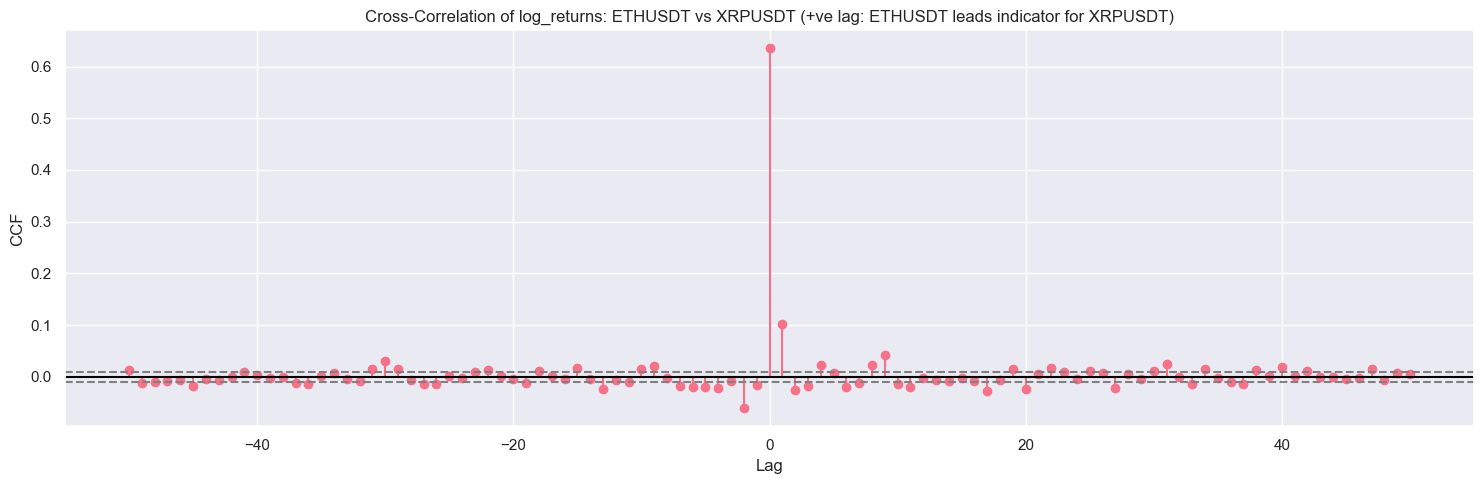

In [15]:
# Load data
all_data, returns_data = load_and_prepare_data()

# Plot ACF analysis for log returns
print("ACF Analysis of Log Returns")
plot_acf_analysis(returns_data, diff_type="log_returns")

# Plot CCF analysis for log returns
print("\nCCF Analysis of Log Returns")
plot_ccf_analysis(returns_data, diff_type="log_returns")


In [76]:
# Show summary of lead-lag relationships
summary_df = create_lead_lag_summary(returns_data)
print("Summary of Strongest Lead-Lag Relationships:")
print(summary_df)


Summary of Strongest Lead-Lag Relationships:
      Leader    Lagger  Lag (minutes)  Correlation
4    ADAUSDT   XRPUSDT              0     0.129604
13  DOGEUSDT   XRPUSDT              0     0.120259
14   ETHUSDT   XRPUSDT              0     0.101110
8    BNBUSDT   XRPUSDT              0     0.100618
11   BTCUSDT   XRPUSDT              0     0.096644
9    BTCUSDT  DOGEUSDT              0     0.058017
12  DOGEUSDT   ETHUSDT              1    -0.053214
2    ADAUSDT  DOGEUSDT              0     0.052535
1    ADAUSDT   BTCUSDT              1    -0.051754
6    BNBUSDT  DOGEUSDT              0     0.050441
10   ETHUSDT   BTCUSDT              2    -0.048976
0    BNBUSDT   ADAUSDT              1     0.045379
3    ADAUSDT   ETHUSDT              1    -0.038502
5    BNBUSDT   BTCUSDT              1    -0.033925
7    ETHUSDT   BNBUSDT             13    -0.028151


### Vol Analysis

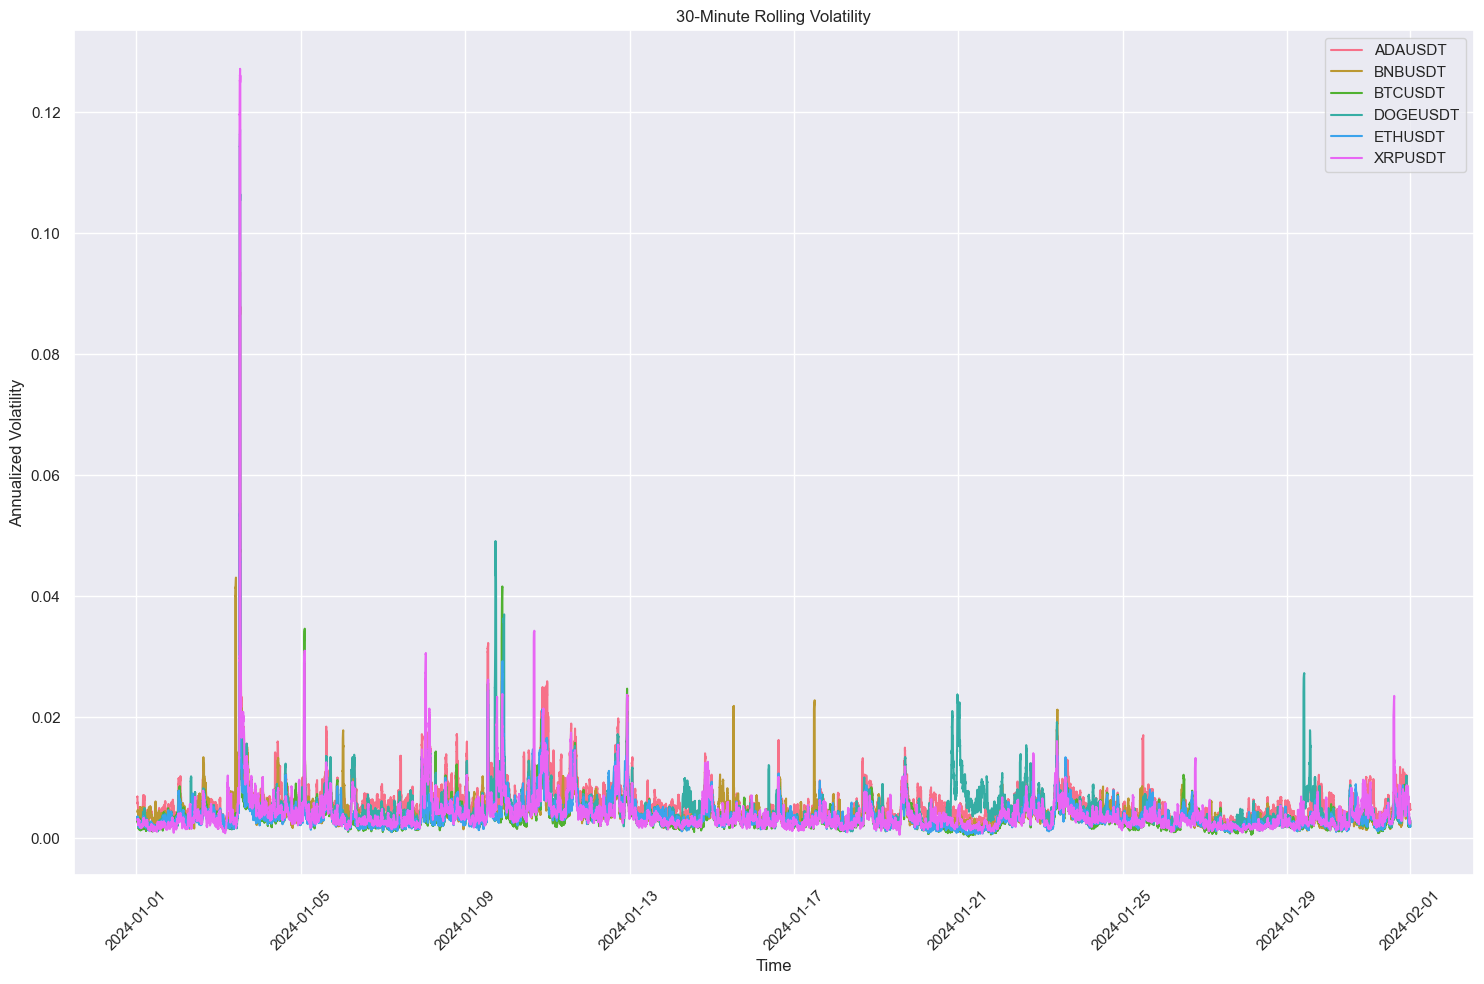

In [77]:
# Volatility Analysis
# Calculate rolling volatility (30-minute window)
plt.figure(figsize=(15, 10))
for symbol, returns in returns_data.items():
    vol = returns['log_returns'].rolling(window=30).std() * np.sqrt(30)
    plt.plot(returns['timestamp'], vol, label=symbol)

plt.title('30-Minute Rolling Volatility')
plt.xlabel('Time')
plt.ylabel('Annualized Volatility')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### Returns Distribution

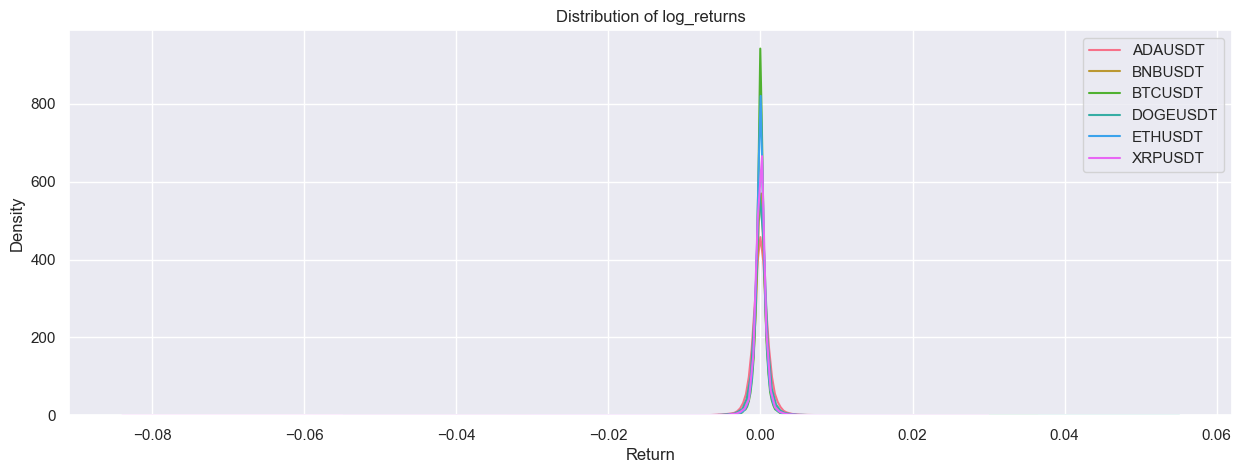

In [ ]:
plot_returns_distribution(returns_data, "log_returns")

In [ ]:
# Load data
returns_data = load_and_prepare_data()

# Plot QQ plots vs normal distribution
print("QQ Plots vs Normal Distribution")
plot_qq_normal(returns_data)

# Plot QQ plots between pairs
print("\nQQ Plots Between Cryptocurrency Pairs")
plot_qq_pairs(returns_data)

In [ ]:
# Plot correlation heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(
    combined_returns.corr(),
    annot=True,
    cmap='RdYlBu',
    center=0,
    fmt='.2f'
)
plt.title('Correlation Heatmap of Crypto Returns')
plt.tight_layout()
plt.show()

### Granger Causality

In [16]:
# src/analysis/granger_causality.py
"""
Granger causality analysis for cryptocurrency returns.

The module provides
    Pairwise Granger Causality:
        Tests causality between all pairs of cryptocurrencies
        Finds optimal lag order for each pair
        Reports significance and p-values
    Multivariate Granger Causality:
        Uses VAR model to test causality in a multivariate setting
        Accounts for interactions between all variables
        Provides test statistics and coefficient p-values
        Automatically selects optimal lag order using AIC
    Summary Statistics:
        Counts significant causal relationships
        Shows which cryptocurrencies are most influential
        Identifies which ones are most affected by others

Key features:

    Handles missing data
    Validates inputs
    Provides detailed logging
    Flexible test statistic selection
    Configurable significance levels
    Optimal lag selection
    Type hints for better code clarity


"""


import logging
from itertools import combinations
from typing import Dict, List, Optional, Tuple, Union

import numpy as np
import pandas as pd
from statsmodels.tools.eval_measures import aic, rmse
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import grangercausalitytests

# Set up logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)


class GrangerCausalityAnalyzer:
    """
    A class to analyze Granger causality relationships in cryptocurrency returns.

    Attributes:
        data (pd.DataFrame): DataFrame containing the return series
        max_lags (int): Maximum number of lags to test
        test_type (str): Type of test statistic to use ('ssr_chi2test', 'ssr_ftest', etc.)
    """

    def __init__(
        self, data: pd.DataFrame, max_lags: int = 10, test_type: str = "ssr_chi2test"
    ):
        """
        Initialize the GrangerCausalityAnalyzer.

        Args:
            data: DataFrame with cryptocurrency returns (each column is a crypto)
            max_lags: Maximum number of lags to test for causality
            test_type: Type of test statistic ('ssr_chi2test', 'ssr_ftest',
                      'ssr_chi2test', 'lrtest')
        """
        self.data = data
        self.max_lags = max_lags
        self.test_type = test_type
        self._validate_inputs()

    def _validate_inputs(self) -> None:
        """Validate input data and parameters."""
        if not isinstance(self.data, pd.DataFrame):
            raise TypeError("Data must be a pandas DataFrame")

        if self.data.isnull().any().any():
            logger.warning("Data contains null values. These will be dropped.")
            self.data = self.data.dropna()

        valid_tests = ["ssr_chi2test", "ssr_ftest", "lrtest", "params_ftest"]
        if self.test_type not in valid_tests:
            raise ValueError(f"test_type must be one of {valid_tests}")

    def run_pairwise_causality(self, significance_level: float = 0.05) -> pd.DataFrame:
        """
        Run pairwise Granger causality tests between all pairs of cryptocurrencies.

        Args:
            significance_level: P-value threshold for significance

        Returns:
            DataFrame containing test results for each pair
        """
        results = []
        pairs = combinations(self.data.columns, 2)

        for coin1, coin2 in pairs:
            # Test coin1 Granger-causing coin2
            c1_to_c2 = self._test_pair_causality(coin1, coin2)

            # Test coin2 Granger-causing coin1
            c2_to_c1 = self._test_pair_causality(coin2, coin1)

            results.extend(
                [
                    {
                        "cause": coin1,
                        "effect": coin2,
                        "min_p_value": c1_to_c2["min_p_value"],
                        "optimal_lag": c1_to_c2["optimal_lag"],
                        "significant": c1_to_c2["min_p_value"] < significance_level,
                    },
                    {
                        "cause": coin2,
                        "effect": coin1,
                        "min_p_value": c2_to_c1["min_p_value"],
                        "optimal_lag": c2_to_c1["optimal_lag"],
                        "significant": c2_to_c1["min_p_value"] < significance_level,
                    },
                ]
            )

        return pd.DataFrame(results)

    def _test_pair_causality(
        self, cause: str, effect: str
    ) -> Dict[str, Union[float, int]]:
        """
        Test Granger causality between a pair of cryptocurrencies.

        Args:
            cause: Name of potential causing variable
            effect: Name of potential effect variable

        Returns:
            Dictionary containing test results
        """
        data = self.data[[cause, effect]].dropna()
        test_results = grangercausalitytests(data, maxlag=self.max_lags, verbose=False)

        # Extract p-values for the specified test type
        p_values = [
            test_results[i + 1][0][self.test_type][1] for i in range(self.max_lags)
        ]

        min_p_value = min(p_values)
        optimal_lag = p_values.index(min_p_value) + 1

        return {"min_p_value": min_p_value, "optimal_lag": optimal_lag}

    def run_multivariate_causality(
        self, target: str, max_lag: Optional[int] = None
    ) -> Tuple[Dict[str, float], Dict[str, List[float]], int]:
        """
        Run multivariate Granger causality analysis using VAR model.

        Args:
            target: Target cryptocurrency to test causality for
            max_lag: Maximum lag order for VAR model (default: None, uses AIC)

        Returns:
            Tuple containing:
            - Dictionary of test statistics for each variable
            - Dictionary of coefficient p-values for each variable
            - Optimal lag order
        """
        # Prepare data
        data = self.data.copy()

        # Determine optimal lag order if not specified
        if max_lag is None:
            model = VAR(data)
            max_lag = model.select_order(maxlags=self.max_lags).aic

        # Fit VAR model
        model = VAR(data)
        results = model.fit(maxlags=max_lag)

        # Get test statistics and p-values for target variable
        target_idx = list(data.columns).index(target)

        # Extract coefficients and p-values for each variable
        coef_pvals = {}
        test_stats = {}

        for i, col in enumerate(data.columns):
            if col != target:
                # Get coefficients for this variable
                coefs = []
                pvals = []
                for lag in range(max_lag):
                    coef_idx = i + lag * len(data.columns)
                    coefs.append(results.params[coef_idx][target_idx])
                    pvals.append(results.pvalues[coef_idx][target_idx])

                coef_pvals[col] = pvals
                # Use F-test or Chi-square test statistic
                test_stats[col] = results.test_causality(
                    target, [col], kind="f"
                ).test_statistic

        return test_stats, coef_pvals, max_lag

    def get_summary_statistics(self, significance_level: float = 0.05) -> pd.DataFrame:
        """
        Generate summary statistics of causality relationships.

        Args:
            significance_level: P-value threshold for significance

        Returns:
            DataFrame with summary statistics
        """
        results = self.run_pairwise_causality(significance_level)

        summary = pd.DataFrame(index=self.data.columns)
        summary["causes_count"] = (
            results[results["significant"]].groupby("cause").size()
        )
        summary["affected_by_count"] = (
            results[results["significant"]].groupby("effect").size()
        )
        summary["total_relationships"] = (
            summary["causes_count"] + summary["affected_by_count"]
        )

        return (
            summary.fillna(0)
            .astype(int)
            .sort_values("total_relationships", ascending=False)
        )


In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from typing import Dict, List, Optional
import logging

class CausalityVisualizer:
    """Visualization tools for Granger causality analysis results."""

    def __init__(self, significance_level: float = 0.05):
        self.significance_level = significance_level
        self.logger = logging.getLogger(__name__)

    def plot_causality_heatmap(
        self,
        causality_results: pd.DataFrame,
        title: Optional[str] = None
    ) -> None:
        """
        Create a heatmap of p-values for Granger causality relationships.

        Args:
            causality_results: DataFrame from GrangerCausalityAnalyzer.run_pairwise_causality()
            title: Optional title for the plot
        """
        # Pivot the results into a matrix
        pivot_df = causality_results.pivot(
            index='cause',
            columns='effect',
            values='min_p_value'
        )

        # Create heatmap
        plt.figure(figsize=(12, 8))
        sns.heatmap(
            pivot_df,
            annot=True,
            cmap='RdYlBu_r',
            vmin=0,
            vmax=0.1,
            center=self.significance_level,
            fmt='.3f'
        )

        plt.title(title or 'Granger Causality P-values Heatmap')
        plt.tight_layout()
        plt.show()

    def plot_causality_network(
        self,
        causality_results: pd.DataFrame,
        layout: str = 'spring',
        min_edge_width: float = 1.0,
        max_edge_width: float = 5.0,
        node_size: float = 2000,
        title: Optional[str] = None
    ) -> None:
        """
        Create a directed graph visualization of significant causal relationships.

        Args:
            causality_results: DataFrame from GrangerCausalityAnalyzer.run_pairwise_causality()
            layout: Graph layout algorithm ('spring', 'circular', 'kamada_kawai')
            min_edge_width: Minimum edge width for visualization
            max_edge_width: Maximum edge width for visualization
            node_size: Size of nodes in the graph
            title: Optional title for the plot
        """
        # Create directed graph
        G = nx.DiGraph()

        # Add nodes
        unique_cryptos = pd.concat([
            causality_results['cause'],
            causality_results['effect']
        ]).unique()
        G.add_nodes_from(unique_cryptos)

        # Add edges for significant relationships
        significant_results = causality_results[
            causality_results['min_p_value'] < self.significance_level
        ]

        # Calculate edge weights based on -log(p-value)
        max_weight = -np.log(significant_results['min_p_value'].min())
        min_weight = -np.log(self.significance_level)

        for _, row in significant_results.iterrows():
            weight = -np.log(row['min_p_value'])
            # Normalize weight for edge width
            edge_width = (
                (weight - min_weight)
                / (max_weight - min_weight)
                * (max_edge_width - min_edge_width)
                + min_edge_width
            )
            G.add_edge(
                row['cause'],
                row['effect'],
                weight=weight,
                width=edge_width
            )

        # Create plot
        plt.figure(figsize=(12, 8))

        # Set layout
        if layout == 'spring':
            pos = nx.spring_layout(G, k=1, iterations=50)
        elif layout == 'circular':
            pos = nx.circular_layout(G)
        else:
            pos = nx.kamada_kawai_layout(G)

        # Draw nodes
        nx.draw_networkx_nodes(
            G, pos,
            node_color='lightblue',
            node_size=node_size,
            alpha=0.7
        )

        # Draw edges with varying widths
        edges = G.edges(data=True)
        edge_widths = [d['width'] for _, _, d in edges]
        nx.draw_networkx_edges(
            G, pos,
            edgelist=edges,
            width=edge_widths,
            edge_color='gray',
            arrowsize=20,
            alpha=0.6
        )

        # Add labels
        nx.draw_networkx_labels(G, pos)

        plt.title(title or 'Granger Causality Network')
        plt.axis('off')
        plt.tight_layout()
        plt.show()

    def plot_summary_bars(
        self,
        summary_stats: pd.DataFrame,
        title: Optional[str] = None
    ) -> None:
        """
        Create bar plots showing causality influence summary statistics.

        Args:
            summary_stats: DataFrame from GrangerCausalityAnalyzer.get_summary_statistics()
            title: Optional title for the plot
        """
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

        # Plot causes count
        summary_stats['causes_count'].plot(
            kind='bar',
            ax=ax1,
            color='skyblue'
        )
        ax1.set_title('Number of Cryptocurrencies Caused')
        ax1.set_ylabel('Count')
        plt.setp(ax1.get_xticklabels(), rotation=45)

        # Plot affected by count
        summary_stats['affected_by_count'].plot(
            kind='bar',
            ax=ax2,
            color='lightgreen'
        )
        ax2.set_title('Number of Cryptocurrencies Affected By')
        ax2.set_ylabel('Count')
        plt.setp(ax2.get_xticklabels(), rotation=45)

        if title:
            fig.suptitle(title)

        plt.tight_layout()
        plt.show()

    def plot_lag_distribution(
        self,
        causality_results: pd.DataFrame,
        title: Optional[str] = None
    ) -> None:
        """
        Plot the distribution of optimal lag orders for significant relationships.

        Args:
            causality_results: DataFrame from GrangerCausalityAnalyzer.run_pairwise_causality()
            title: Optional title for the plot
        """
        significant_results = causality_results[
            causality_results['min_p_value'] < self.significance_level
        ]

        plt.figure(figsize=(10, 6))
        sns.histplot(
            data=significant_results,
            x='optimal_lag',
            bins=range(
                significant_results['optimal_lag'].min(),
                significant_results['optimal_lag'].max() + 2,
                1
            )
        )

        plt.title(title or 'Distribution of Optimal Lag Orders')
        plt.xlabel('Optimal Lag')
        plt.ylabel('Count')
        plt.tight_layout()
        plt.show()


In [50]:
'''
Key features of this implementation:

    Automated Lag Selection:

    Uses VAR model to determine optimal lag structure
    Applies AIC criterion to select best lag order
    Considers both variables simultaneously in the model

    Comprehensive Testing:

    Returns both Chi-square and F-test statistics
    Provides p-values for hypothesis testing
    Includes interpretation of results

    Advantages of this Approach:

    More robust than selecting lags for x and y separately
    Accounts for potential interactions between variables
    Reduces risk of overfitting or underfitting

    Limitations to Consider:

    Assumes stationarity of the time series
    May need larger sample sizes for higher lag orders
    Sensitive to the maximum lag parameter

The code allows for fully automated testing while still giving you
control over key parameters like maximum lags and significance levels.
 This makes it suitable for both individual tests and large-scale analyses
 of multiple variable pairs.

---


'''

import pandas as pd
import pyarrow.parquet as pq
import numpy as np
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import grangercausalitytests
import glob
import os
from typing import Dict, Tuple, List
# from .src.visualization.causality_viz import CausalityVisualizer
import logging

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

class AutomatedGrangerAnalyzer:
    def __init__(self, data_dir: str = "../data/processed/"):
        """ 
        Initialize analyzer with data directory path.

        Args:
            data_dir: Directory containing processed parquet files
        """
        self.data_dir = data_dir
        self.returns_data = self._load_data()
        self.hourly_data = self.returns_data.resample(rule=)
        self.visualizer = CausalityVisualizer(significance_level=0.05)

    def _load_data(self) -> pd.DataFrame:
        """Load and prepare return data from parquet files."""
        all_returns = {}

        for file in glob.glob(os.path.join(self.data_dir, "*.parquet")):
            symbol = os.path.basename(file).split('_')[0]
            df = pq.read_table(file).to_pandas()
            # Calculate log returns if not already present
            if 'log_returns' not in df.columns:
                df['log_returns'] = np.log(df['close']).diff()
            all_returns[symbol] = df['log_returns']

        returns_df = pd.DataFrame(all_returns).dropna()
        return returns_df

    def select_optimal_lag(self, data: pd.DataFrame, max_lags: int = 10) -> int:
        """Select optimal lag order using AIC criterion."""
        model = VAR(data)
        results = model.select_order(maxlags=max_lags)
        return results.aic

    def test_pair_causality(
        self,
        cause: str,
        effect: str,
        max_lags: int = 10
    ) -> Tuple[Dict, int]:
        """
        Test Granger causality between a pair of cryptocurrencies.

        Args:
            cause: Name of potential causing variable
            effect: Name of potential effect variable
            max_lags: Maximum number of lags to test

        Returns:
            Tuple containing test results and optimal lag order
        """
        # Prepare data
        pair_data = self.returns_data[[cause, effect]].dropna()

        # Find optimal lag order
        optimal_lag = self.select_optimal_lag(pair_data, max_lags)

        # Run Granger causality test
        gc_results = grangercausalitytests(
            pair_data[[effect, cause]],  # effect must come first
            maxlag=optimal_lag,
            verbose=False
        )

        # Extract results
        test_stats = {}
        for test_type in ['ssr_chi2test', 'ssr_ftest']:
            test_stats[test_type] = {
                'stat': gc_results[optimal_lag][0][test_type][0],
                'pvalue': gc_results[optimal_lag][0][test_type][1]
            }

        return test_stats, optimal_lag

    def analyze_all_pairs(
        self,
        significance_level: float = 0.05
    ) -> pd.DataFrame:
        """
        Analyze Granger causality for all cryptocurrency pairs.

        Returns:
            DataFrame with causality test results
        """
        results = []
        symbols = self.returns_data.columns

        for cause in symbols:
            for effect in symbols:
                if cause != effect:
                    test_stats, opt_lag = self.test_pair_causality(cause, effect)

                    results.append({
                        'cause': cause,
                        'effect': effect,
                        'optimal_lag': opt_lag,
                        'f_stat': test_stats['ssr_ftest']['stat'],
                        'p_value': test_stats['ssr_ftest']['pvalue'],
                        'significant': test_stats['ssr_ftest']['pvalue'] < significance_level
                    })

        return pd.DataFrame(results)

    def visualize_results(self, results: pd.DataFrame) -> None:
        """Create visualizations of causality results."""
        # Create heatmap of p-values
        self.visualizer.plot_causality_heatmap(
            results,
            title='Automated Granger Causality P-values'
        )

        # Create network diagram
        self.visualizer.plot_causality_network(
            results,
            title='Automated Granger Causality Network'
        )

def main():
    """Main analysis pipeline."""
    # Initialize analyzer
    analyzer = AutomatedGrangerAnalyzer()

    # Run analysis
    logger.info("Running automated Granger causality analysis...")
    results = analyzer.analyze_all_pairs()

    # Print summary
    significant_results = results[results['significant']]
    print("\nSignificant Granger Causality Relationships:")
    for _, row in significant_results.iterrows():
        print(f"{row['cause']} -> {row['effect']}")
        print(f"  Optimal lag: {row['optimal_lag']}")
        print(f"  F-statistic: {row['f_stat']:.4f}")
        print(f"  P-value: {row['p_value']:.4f}\n")

    # Create visualizations
    logger.info("Creating visualizations...")
    analyzer.visualize_results(results)

In [51]:
ga = AutomatedGrangerAnalyzer()

In [52]:
ga._load_data()

,ADAUSDT,BNBUSDT,BTCUSDT,DOGEUSDT,ETHUSDT,XRPUSDT
1,0.001178,0.000961,0.000506,0.000558,0.000771,0.000650
2,0.000168,0.001280,0.000130,-0.000223,0.000188,0.000649
3,0.002015,0.000320,0.001003,0.001338,0.000866,0.000324
4,0.001844,0.000639,0.000690,0.000557,0.000643,0.000486
5,-0.002515,0.000319,0.000282,0.000223,0.000752,0.000486
...,...,...,...,...,...,...
44636,0.000602,0.000333,0.000066,0.000381,-0.000039,0.000397
44637,0.000000,-0.000333,0.000000,-0.000127,-0.000022,-0.000794
44638,-0.001405,-0.000333,-0.000653,-0.000761,-0.000495,-0.000199
44639,-0.000402,0.000333,-0.000235,-0.000254,0.000057,0.000199


In [57]:
ga.analyze_all_pairs()

c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning:

verbose is deprecated since functions should not print results

c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning:

verbose is deprecated since functions should not print results

c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning:

verbose is deprecated since functions should not print results

c

,cause,effect,optimal_lag,f_stat,p_value,significant
0,ADAUSDT,BNBUSDT,10,25.702972,2.548720e-49,True
1,ADAUSDT,BTCUSDT,10,10.685363,2.425227e-18,True
2,ADAUSDT,DOGEUSDT,10,25.386682,1.169526e-48,True
3,ADAUSDT,ETHUSDT,10,13.850268,9.394460e-25,True
4,ADAUSDT,XRPUSDT,10,43.228429,3.410562e-86,True
5,BNBUSDT,ADAUSDT,10,8.836594,1.170349e-14,True
6,BNBUSDT,BTCUSDT,10,8.815782,1.286555e-14,True
7,BNBUSDT,DOGEUSDT,10,16.900292,5.158153e-31,True
8,BNBUSDT,ETHUSDT,10,6.495121,4.217585e-10,True
9,BNBUSDT,XRPUSDT,10,35.778803,1.751795e-70,True


In [56]:
ga.select_optimal_lag(ga.returns_data)

c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.



10

In [55]:
ga.test_pair_causality("BTCUSDT","ADAUSDT")

c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning:

verbose is deprecated since functions should not print results



({'ssr_chi2test': {'stat': 100.42421971139409,
   'pvalue': 4.4818362820023353e-17},
  'ssr_ftest': {'stat': 10.037696654953123, 'pvalue': 4.804970723135786e-17}},
 10)